In [1]:
import pandas as pd
#Load libraries
from sklearn.preprocessing import PowerTransformer
import numpy as np
from kmodes.kprototypes import KPrototypes
#Load libraries
from matplotlib import style
from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Load library
from sklearn.preprocessing import LabelEncoder
import os
import random

/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/apps/jupyterhub/2019-04-29/miniconda

In [2]:
#Import dataset for unsupervised clustering
df_unsup = pd.read_csv('/rds/general/user/md2620/home/asthma/Malo/Dataframes/Final/unsup_df_all_processed.csv', low_memory=False)

In [3]:
df_unsup.head(5)

,Unnamed: 0,Unnamed: 0.1,Biomarker.C5a.pg.ml.serum,Biomarker.CD30.pg.ml.serum,Biomarker.CD40L.pg.ml.serum,Biomarker.DPPIV.pg.ml.serum,Biomarker.Galectin.3.pg.ml.serum,Biomarker.IL.18.pg.ml.serum,Biomarker.IL.1alpha.pg.ml.serum,Biomarker.IL.6Ralpha.pg.ml.serum,...,cluster_K_11,cluster_K_12,cluster_K_13,cluster_K_14,cluster_K_15,Healthy,MildModerate,Severe,Severe_Smoker,Severe_asthma
0,0,A_237,-0.389563,1.594876,1.189472,0.548141,0.386750,2.247782,-0.346972,0.194263,...,6,10,10,10,8,No,No,Yes,No,Yes
1,1,A_132,-0.903106,0.051530,1.238507,-0.428928,-0.724336,1.332508,0.486837,3.146578,...,2,9,4,9,14,Yes,No,No,No,No
2,2,A_074,-0.283828,0.565457,0.937791,2.490261,-0.242094,1.676125,-0.210161,0.820350,...,7,12,3,10,15,Yes,No,No,No,No
3,3,A_335,1.242211,0.117235,-0.560012,-0.137712,1.823275,0.685887,0.345774,-0.011499,...,5,11,5,7,10,No,No,Yes,No,Yes
4,4,A_418,0.304558,0.300170,-0.286963,2.208245,-1.080138,0.222411,0.771334,0.032724,...,5,11,9,7,11,No,No,No,Yes,Yes


In [4]:
#Check variable types for specific columns using:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df_unsup.iloc[:,363:383].dtypes

cohort           object
cluster_K_2       int64
cluster_K_3       int64
cluster_K_4       int64
cluster_K_5       int64
cluster_K_6       int64
cluster_K_7       int64
cluster_K_8       int64
cluster_K_9       int64
cluster_K_10      int64
cluster_K_11      int64
cluster_K_12      int64
cluster_K_13      int64
cluster_K_14      int64
cluster_K_15      int64
Healthy          object
MildModerate     object
Severe           object
Severe_Smoker    object
Severe_asthma    object
dtype: object

In [5]:
#Drop a few columns from df_sup to run k-prototypes (K=2 to 10)
df_unsup_proto = df_unsup.drop(['cluster_K_2','cohort','cluster_K_3','cluster_K_4','cluster_K_5','cluster_K_6','cluster_K_7','cluster_K_8','cluster_K_9','cluster_K_10','cluster_K_11','cluster_K_12','cluster_K_13','cluster_K_14','cluster_K_15','Healthy','Severe','Severe_Smoker','Severe_asthma','MildModerate','Unnamed: 0','Omics.Xylose','Omics.Xanthosine','Omics.Furoylglycine','Omics.Allantoin',
'Omics.Cytosine','Omics.Glucosamine','Omics.Glutamic.acid',
'Omics.Isoleucine','Omics.Lysine','Omics.Maltose',
'Omics.N.Acetylglutamic.acid','Omics.N.Methyl.D.aspartic.acid','Omics.O.Acetylserine',
'Omics.Phenylalanine','Omics.Sarcosine','Omics.N.Acetylputrescine'], axis = 1)

In [6]:
df_unsup_proto.head(5)

,Unnamed: 0.1,Biomarker.C5a.pg.ml.serum,Biomarker.CD30.pg.ml.serum,Biomarker.CD40L.pg.ml.serum,Biomarker.DPPIV.pg.ml.serum,Biomarker.Galectin.3.pg.ml.serum,Biomarker.IL.18.pg.ml.serum,Biomarker.IL.1alpha.pg.ml.serum,Biomarker.IL.6Ralpha.pg.ml.serum,Biomarker.LBP.pg.ml.serum,Biomarker.Lumican.pg.ml.serum,Biomarker.MCP.4.pg.ml.serum,Biomarker.MMP.3.pg.ml.serum,Biomarker.RAGE.pg.ml.serum,Biomarker.SHBG.pg.ml.serum,Biomarker.Serpin.E1.pg.ml.serum,Biomarker.alpha1.microglobulin.pg.ml.serum,Biomarker.CCL17.pg.ml.MSD.BL.plasma,Biomarker.CCL22.pg.ml.MSD.BL.plasma,Biomarker.EOTAXIN.pg.ml.MSD.BL.plasma,Biomarker.EOTAXIN3.pg.ml.MSD.BL.plasma,Biomarker.Baseline.BI.Cytokines.Chemokines.IFNg.pg.ml.MSD.BL.plasma,Biomarker.Baseline.BI.Cytokines.Chemokines.IL6.pg.ml.MSD.BL.plasma,Biomarker.IL8.pg.ml.MSD.BL.plasma,Biomarker.IP10.pg.ml.MSD.BL.plasma,Biomarker.MCP1.pg.ml.MSD.BL.plasma,Biomarker.MIP1b.pg.ml.MSD.BL.plasma,Biomarker.TNFa.pg.ml.MSD.BL.plasma,Biomarker.Genentech.CCL18.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.IL13.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.Periostin.ng.ml.ELECSYS.BL.serum,Biomarker.Karolinska.hsCRP.hCRP.mg.L,Clinical.Atopy.Total.IgE.IU.ml,Clinical.Screening.Electrocardiogram.Qtc.Interval.,Clinical.NO.Standard.Flow.Rate,Clinical.Screening.Albumin.g.dL,Clinical.Screening.Alkaline.Phosphatase.U.L,Clinical.Screening.Alt.U.L.,Clinical.Screening.Ast.U.L,Clinical.Screening.Basophils,Clinical.Screening.Blood.Urea.Nitrogen.mg.dL,Clinical.Screening.Creatinine.umol.L,Clinical.Screening.Gamma.Gt.U.L,Clinical.Screening.Haemoglobin.g.dL,Clinical.Screening.Lymphocytes,Clinical.Screening.Monocytes,Clinical.Screening.Platelets.x10.3.uL,Clinical.Screening.Potassium.mmol.L,Clinical.Screening.Sodium.mmol.L,Clinical.Screening.Total.Bilirubin.umol.L,Clinical.Screening.Total.Protein.g.dL,Clinical.Screening.Wbcs.x10.3.uL,Clinical.Screening.basophils.x10.3.u,Clinical.Screening.lymphocytes.x10.3.uL,Clinical.Screening.monocytes.x10.3.uL,Clinical.FEF.25.75.Absolute.Change.L.sec,Clinical.FEF.25.75.Change.L.sec,Clinical.FEV1.Change,Clinical.FEV1.FVC.Ratio.Predicted.LLN,Clinical.FEV1.FVC.Ratio.Predicted,Clinical.FVC.Absolute.Change.L,Clinical.PEF.Change.L.sec,Clinical.Baseline.PEF,Clinical.Screening.Diastolic.Blood.Pressure,Clinical.Screening.Heart.Rate,Clinical.Screening.Respiratory.Rate,Clinical.Screening.Systolic.Blood.Pressure,Exacerbation.Per.Year.,Omics.dehydroTXB2.ng.mmolC,Omics.dinor.11.B.PGF2a.ng.mmolC,Omics.dinor.8.isoPGF2a.ng.mmolC,Omics.dinor.TXB2.ng.mmolC,Omics.iso.iPF2a.VI.ng.mmolC,Omics.isoPGF2a.ng.mmolC,Omics.LTE4.ng.mmolC,Omics.PGE2.ng.mmolC,Omics.PGF2a.ng.mmolC,Omics.tetranorPGDM.ng.mmolC,Omics.tetranorPGEM.ng.mmolC,Omics.Trimethyluric.acid,Omics.Dimethyluric.acid,Omics.Methyluric.acid,Omics.Hydroxybutyric.acid,Omics.Hydroxykynurenine,Omics.Hydroxyproline,Omics.Methylhistidine,Omics.Methylxanthine,Omics.Pyridoxic.acid,Omics.Acetylamino.6.formylamino.3.methyluracil,Omics.Aminolevulinic.acid,Omics.Hydroxyindoleacetic.acid,Omics.Methylguanine,Omics.Acetylcarnitine,Omics.Alanine,Omics.Aminocaproic.acid,Omics.Aminovaleric.acid,Omics.Aspartic.acid,Omics.Betaine,Omics.Biopterin,Omics.Caffeine,Omics.Carnitine,Omics.Carnosine,Omics.Choline,Omics.Citrulline,Omics.Cystathionine,Omics.Galacturonic.acid,Omics.Glutamine,Omics.Guanine,Omics.Guanosine,Omics.Hippuric.acid,Omics.Histidine,Omics.Hydroxyphenylacetic.acid,Omics.Hypoxanthine,Omics.Inosine,Omics.Kynurenic.acid,Omics.Mannitol,Omics.Mesaconic.acid,Omics.Metanephrine,Omics.Methionine,Omics.Methylhippuric.acid,Omics.Methylthioadenosine,Omics.N.Acetylcarnosine,Omics.N.Methylhistamine,Omics.Nitrotyrosine,Omics.Ornithine,Omics.Phenylacetylglutamine,Omics.Phenyllactic.acid,Omics.Pipecolic.acid,Omics.Proline,Omics.Propionylcarnitine,Omics.Pyridoxal,Omics.Pyroglutamic.acid,Omics.Pyroglutamylglycine,Omics.S.Adenosylhomocysteine,Omics.Saccharopine,Omics.Serine,Omics.Serotonin,Omics.Sucrose,Omics.Taurine,Omics.Theobromine,Omics.Tryptamine,Omics.Tyramine,Omics.Tyrosine,Omics.Uracil,Omics.Uric.acid,Omi

In [7]:
#Set Unnamed: 0 as index of df_sup_proto
df_unsup_proto = df_unsup_proto.set_index('Unnamed: 0.1')

In [8]:
df_unsup_proto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610 entries, A_237 to A_727
Columns: 345 entries, Biomarker.C5a.pg.ml.serum to Race
dtypes: float64(345)
memory usage: 1.6+ MB


In [9]:
df_unsup_proto.iloc[:,164:345].dtypes

Asthma.Diag.Fev.Variation                                  float64
Asthma.Diag.Pef.Variation                                  float64
Asthma.Diag.Historic.Test                                  float64
Expo.Aspirin                                               float64
Expo.Barns                                                 float64
Expo.Cold.Air                                              float64
Expo.Dust                                                  float64
Expo.Fungus                                                float64
Expo.Menstrual.Cycle                                       float64
Expo.Perfumes                                              float64
Expo.Pets                                                  float64
Expo.Physical.Exercise                                     float64
Expo.Pollen                                                float64
Expo.Pollutants                                            float64
Expo.Respiratory.Infections                                flo

In [10]:
#Convert range of variables 105-113 to category as they are recorded as float64 after the transformation but remain cat variables that need to have a category type for K-prototypes
df_unsup_proto.iloc[:,164:345]=df_unsup_proto.iloc[:,164:345].astype('category')

In [11]:
#Convert df_sup_proto to a numpy array that we call X_df_sup_proto
X_df_unsup_proto = df_unsup_proto.iloc[:,:].values
#Look at shape
X_df_unsup_proto.shape

(610, 345)

In [12]:
#Define categorical columns in df_sup_proto
cat_columns_df_unsup_proto = [163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,
239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,
280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,
321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344]

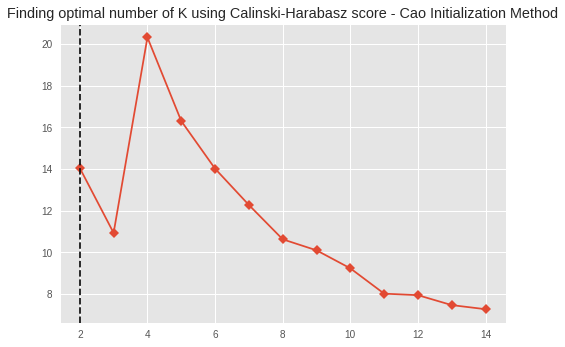

In [60]:
# Calinski Harabasz Score for unsupervised K-prototypes
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KPrototypes(init='Cao')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,15),metric='calinski_harabasz', timings = False)
visualizer.fit(df_unsup_proto,categorical=cat_columns_df_unsup_proto)        # Fit the data to the visualizer
plt.title("Finding optimal number of K using Calinski-Harabasz score - Cao Initialization Method")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results")
plt.savefig('CHindex_optK_Cao_unsupervised.pdf',format='pdf', dpi=1000, bbox_inches='tight')

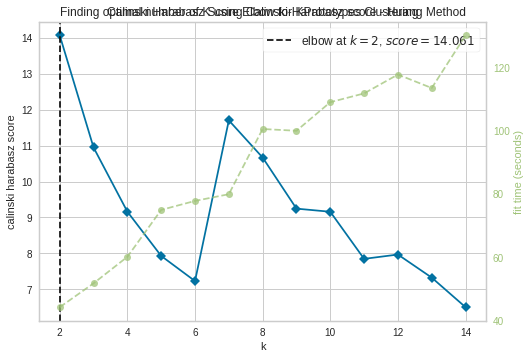

In [67]:
# Calinski Harabasz Score for unsupervised K-prototypes
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model2 = KPrototypes(init='Huang')
# k is range of number of clusters.
visualizer2 = KElbowVisualizer(model2, k=(2,15),metric='calinski_harabasz', timings= True)
visualizer2.fit(df_unsup_proto,categorical=cat_columns_df_unsup_proto)        # Fit the data to the visualizer
plt.title("Finding optimal number of K using Calinski-Harabasz score - Huang Method")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results")
plt.savefig('CHindex_optK_Huang_unsupervised.pdf',format='pdf', dpi=1000, bbox_inches='tight')
visualizer2.show()

In [13]:
#From calinski-harabasz score, optimal number of K is 3 and lambda is 3.1 (seems that library does not handle lambda)
#Run kprototypes with K=3
import random
random.seed(91)
style.use("ggplot")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

kproto_df_unsup = KPrototypes(n_clusters= 3, init='Huang', n_jobs = 4)
cluster_df_unsup = kproto_df_unsup.fit_predict(X_df_unsup_proto, categorical = cat_columns_df_unsup_proto)

# Print cluster centroids of the trained model.
print(kproto_df_unsup.cluster_centroids_)

# Print training statistics
print(kproto_df_unsup.cost_)
print(kproto_df_unsup.n_iter_)

[[ 0.03148742 -0.03997448  0.06263605 ... -0.07030177 -0.87934965
   0.30470877]
 [ 0.18226693  0.15122848  0.15176254 ... -0.07030177 -0.87934965
   0.30470877]
 [-0.187408   -0.09600419 -0.18881975 ... -0.07030177 -0.87934965
   0.30470877]]
111955.57834875275
17


In [14]:
#Print count of each cluster
print(pd.Series(cluster_df_unsup).value_counts())

2    220
0    198
1    192
dtype: int64


In [15]:
#Get kproto_df_scale_cat labels as follow
kproto_df_unsup_labs = kproto_df_unsup.labels_

In [16]:
kproto_df_unsup_labs

array([1, 0, 2, 0, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 0, 0, 0, 2, 2,
       2, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       2, 1, 1, 2, 1, 1, 2, 0, 2, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2, 2, 0, 1,
       2, 0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2,
       1, 2, 2, 1, 1, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 0, 2, 0, 1, 0, 2,
       0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1,
       2, 1, 0, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 0, 1, 1, 2,
       2, 0, 1, 1, 2, 0, 0, 0, 2, 1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 2,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 1, 1, 0,
       1, 2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 2, 0, 1,
       2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 1, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 2, 1, 0, 1,
       0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1,
       2, 0, 1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 0, 2,

In [52]:
#Make a copy of df_sup_proto and set the objects to category 
df_unsup_copy = df_unsup_proto.copy()
for i in df_unsup_copy.select_dtypes(include='object'):
    df_unsup_copy[i] = df_unsup_copy[i].astype('category')

EVALUATION OF CLUSTERING METHOD BY CLASSIFICATION

In [53]:
#Use of LightGBM as my classifier because it handles categorical variables and because it is relatively fast to obtain shap values for the trained models.
clf_unsup_K2 = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_unsup_K2 = cross_val_score(clf_unsup_K2, df_unsup_copy, kproto_df_unsup_labs, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_unsup_K2)}')
#CV score of 0.9245 (close to 1)meaning that the observations are grouped in meaningful and distinguishable clusters.

CV F1 score for K-Prototypes clusters is 0.8384252318793506


In [54]:
clf_unsup_K2.fit(df_unsup_copy, kproto_df_unsup_labs)

LGBMClassifier(colsample_by_tree=0.8)

In [55]:
explainer_unsup_K2 = shap.TreeExplainer(clf_unsup_K2)
shap_values_unsup_K2 = explainer_unsup_K2.shap_values(df_unsup_copy)

2. INFORMATIVENESS OF CLUSTERS BY SHAP FEATURES IMPORTANCE

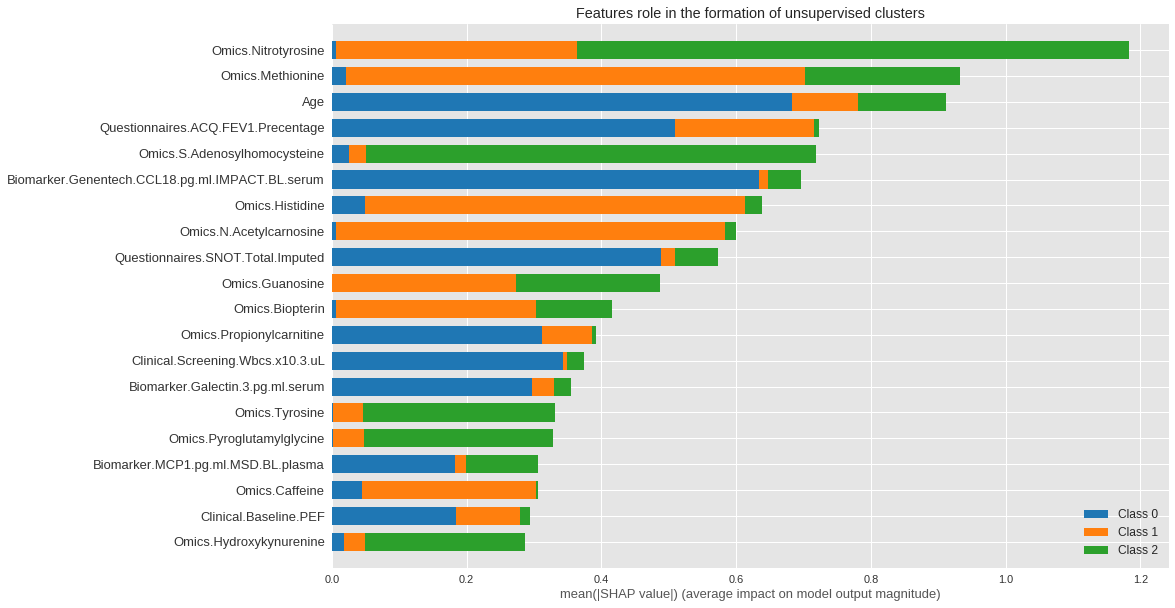

In [56]:
shap.summary_plot(shap_values_unsup_K2, df_unsup_copy, plot_type="bar", plot_size=(15, 10),color=plt.get_cmap("tab10"),show=False)
ax = plt.gca()
plt.title("Features role in the formation of unsupervised clusters")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_2_clusters_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 1

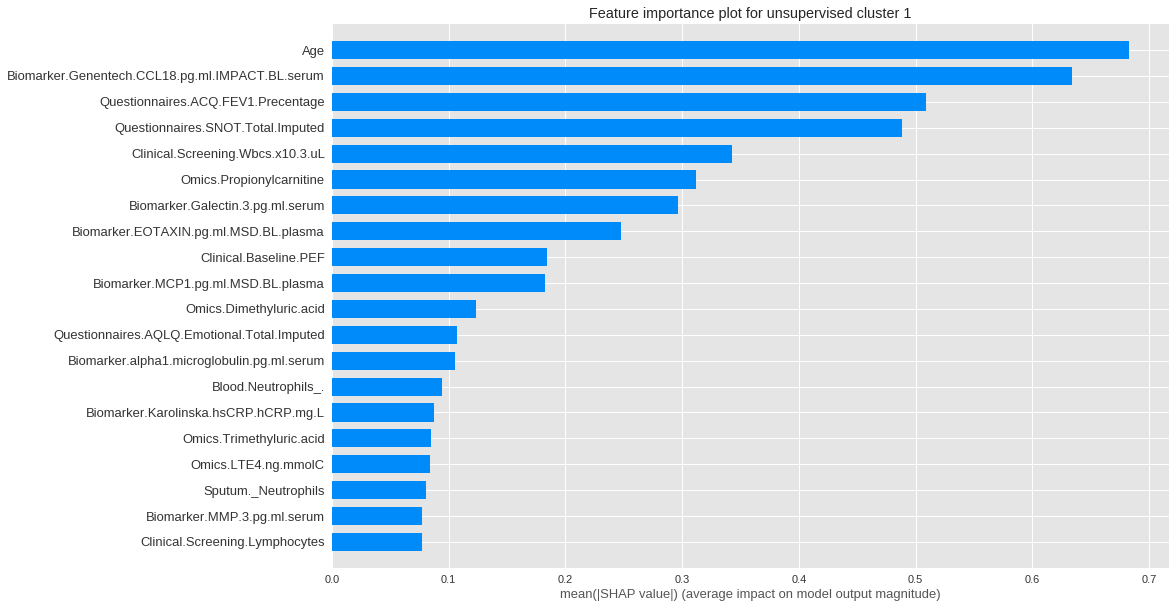

In [57]:
shap.summary_plot(shap_values_unsup_K2[0], df_unsup_copy, plot_type="bar", plot_size=(15, 10),show=False)
ax = plt.gca()
plt.title("Feature importance plot for unsupervised cluster 1")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust1_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 2

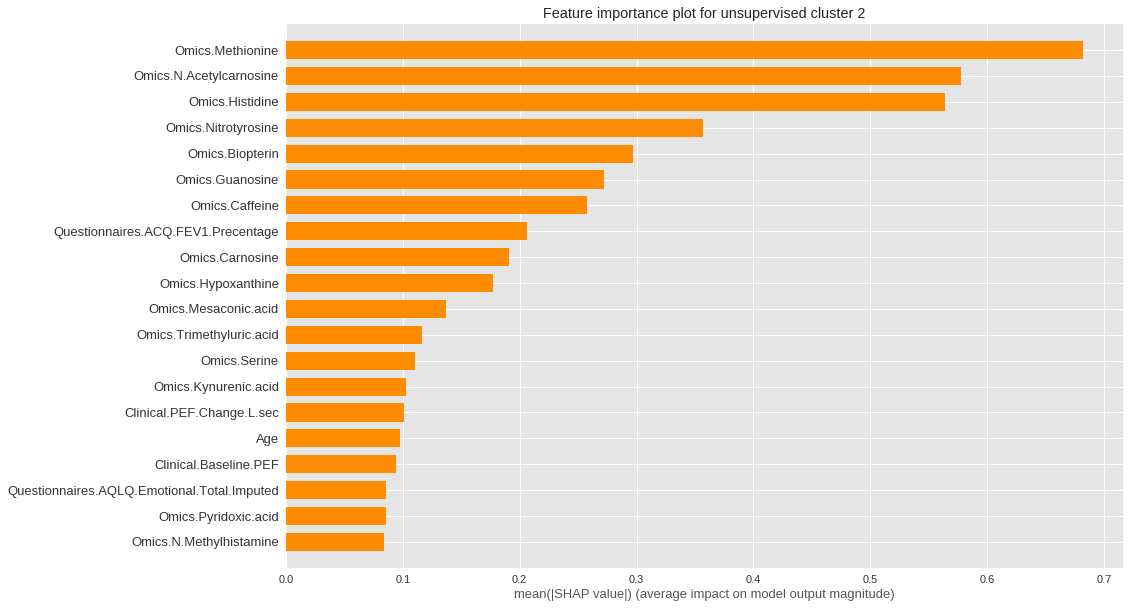

In [58]:
shap.summary_plot(shap_values_unsup_K2[1], df_unsup_copy, plot_type="bar", plot_size=(15, 10),color = "darkorange",show=False)
ax = plt.gca()
plt.title("Feature importance plot for unsupervised cluster 2")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust2_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

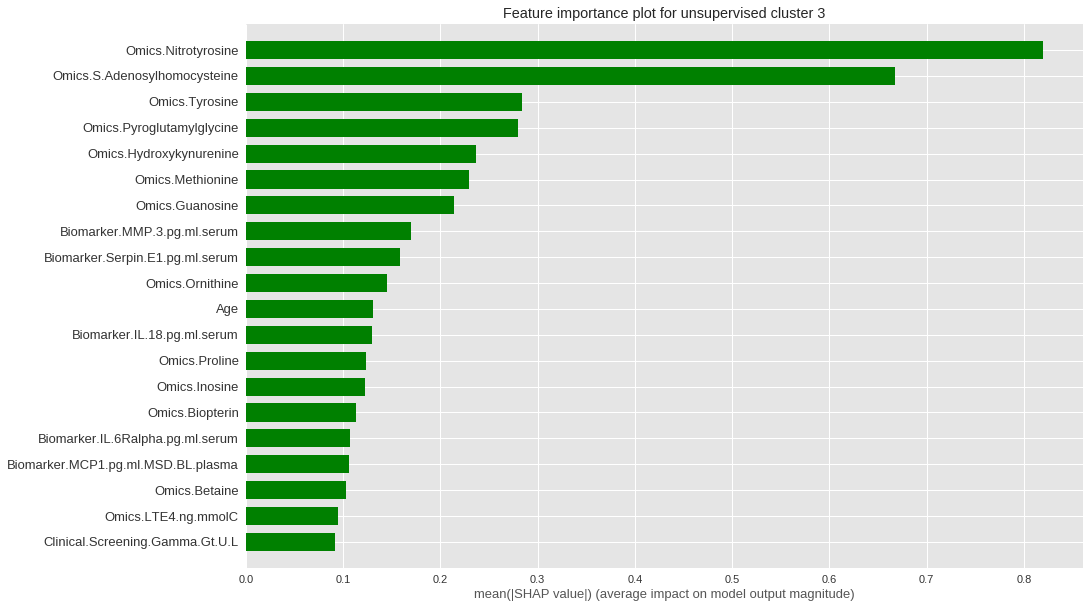

In [59]:
shap.summary_plot(shap_values_unsup_K2[2], df_unsup_copy, plot_type="bar", plot_size=(15, 10),color = "green",show=False)
ax = plt.gca()
plt.title("Feature importance plot for unsupervised cluster 3")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust2_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

REDO ANALYSIS WITH K = 4

In [69]:
#From PCA viz, optimal number of K is 4, CH score using Huang method too.
#Run kprototypes with K=5
import random
random.seed(95)
style.use("ggplot")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

kproto_df_unsup_4 = KPrototypes(n_clusters= 4, init='Huang', n_jobs = 4)
cluster_df_unsup_4 = kproto_df_unsup_4.fit_predict(X_df_unsup_proto, categorical = cat_columns_df_unsup_proto)

# Print cluster centroids of the trained model.
print(kproto_df_unsup_4.cluster_centroids_)

# Print training statistics
print(kproto_df_unsup_4.cost_)
print(kproto_df_unsup_4.n_iter_)

[[-0.19962574 -0.0985434  -0.19659974 ... -0.07030177 -0.87934965
   0.30470877]
 [-0.05330131  0.00229556 -0.18390981 ... -0.07030177 -0.87934965
   0.30470877]
 [ 0.22933583 -0.03160492  0.28508201 ... -0.07030177 -0.87934965
   0.30470877]
 [ 0.0925994   0.15436267  0.1607396  ... -0.07030177  1.13720406
   0.30470877]]
109402.32054253768
8


In [70]:
#Print count of each cluster
print(pd.Series(cluster_df_unsup_4).value_counts())

0    188
3    146
1    139
2    137
dtype: int64


In [71]:
#Get kproto_df_scale_cat labels as follow
kproto_df_unsup_labs_4 = kproto_df_unsup_4.labels_

In [72]:
#Make a copy of df_sup_proto and set the objects to category 
df_unsup_copy_4 = df_unsup_proto.copy()
for i in df_unsup_copy_4.select_dtypes(include='object'):
    df_unsup_copy_4[i] = df_unsup_copy_4[i].astype('category')

EVALUATION OF CLUSTERING METHOD BY CLASSIFICATION FOR K=4

In [73]:
#Use of LightGBM as my classifier because it handles categorical variables and because it is relatively fast to obtain shap values for the trained models.
clf_unsup_K4 = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_unsup_K4 = cross_val_score(clf_unsup_K4, df_unsup_copy_4, kproto_df_unsup_labs_4, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_unsup_K4)}')
#CV score of 0.8291 (less close to 1 but still pretty good) meaning that the observations are less grouped in meaningful and distinguishable clusters.

CV F1 score for K-Prototypes clusters is 0.8291532213907704


In [74]:
clf_unsup_K4.fit(df_unsup_copy_4, kproto_df_unsup_labs_4)

LGBMClassifier(colsample_by_tree=0.8)

In [75]:
explainer_unsup_K4 = shap.TreeExplainer(clf_unsup_K4)
shap_values_unsup_K4 = explainer_unsup_K4.shap_values(df_unsup_copy_4)

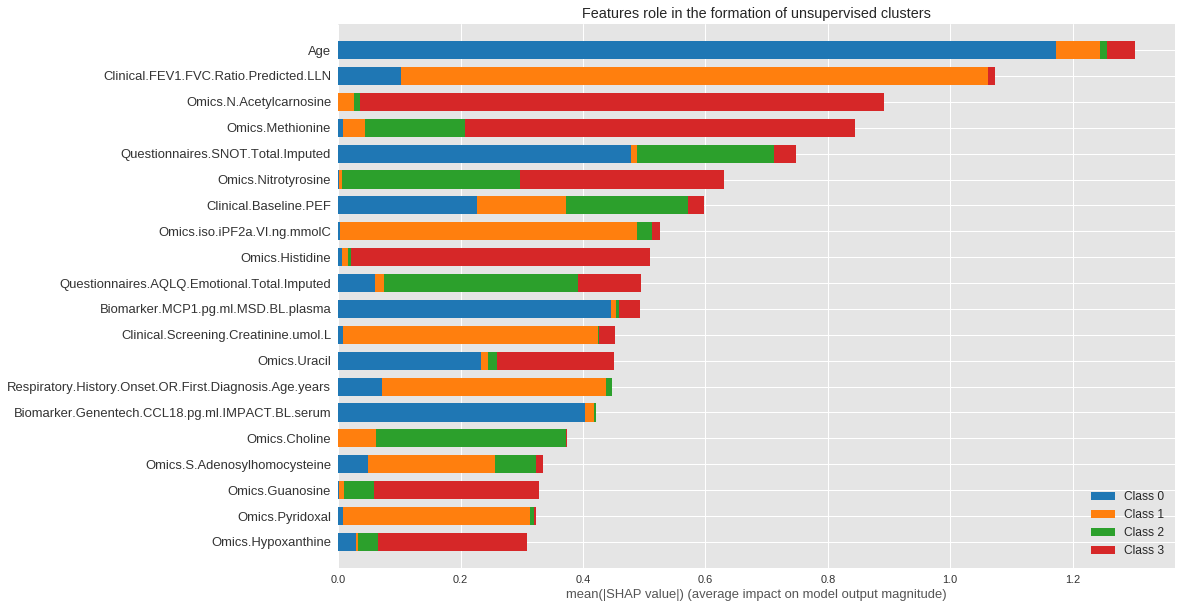

In [76]:
shap.summary_plot(shap_values_unsup_K4, df_unsup_copy_4, plot_type="bar", plot_size=(15, 10),color=plt.get_cmap("tab10"),show=False)
ax = plt.gca()
plt.title("Features role in the formation of unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_4_clusters_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 1

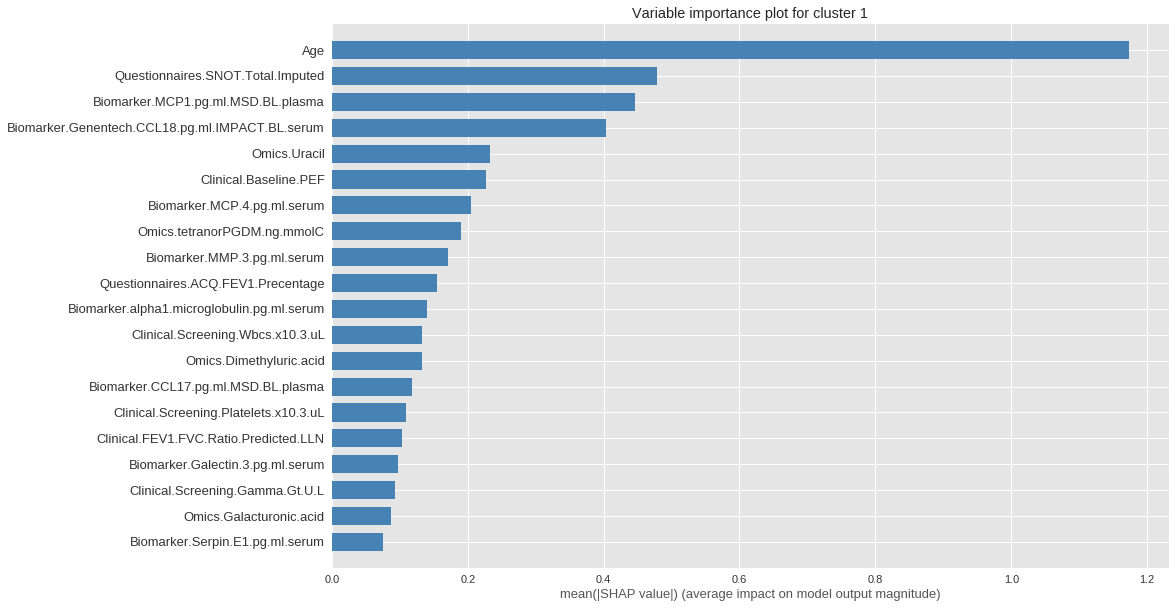

In [81]:
shap.summary_plot(shap_values_unsup_K4[0], df_unsup_copy_4, plot_type="bar", plot_size=(15, 10),color="steelblue",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 1")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust1_K4unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 2

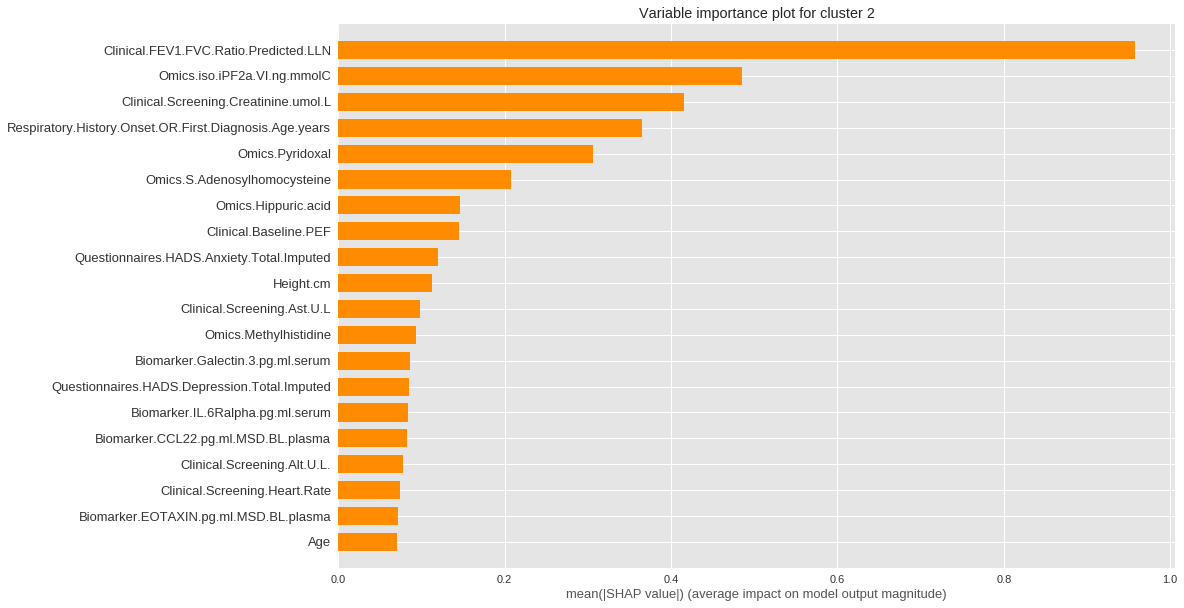

In [78]:
shap.summary_plot(shap_values_unsup_K4[1], df_unsup_copy_4, plot_type="bar", plot_size=(15, 10),color="darkorange",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 2")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust2_K4unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 3

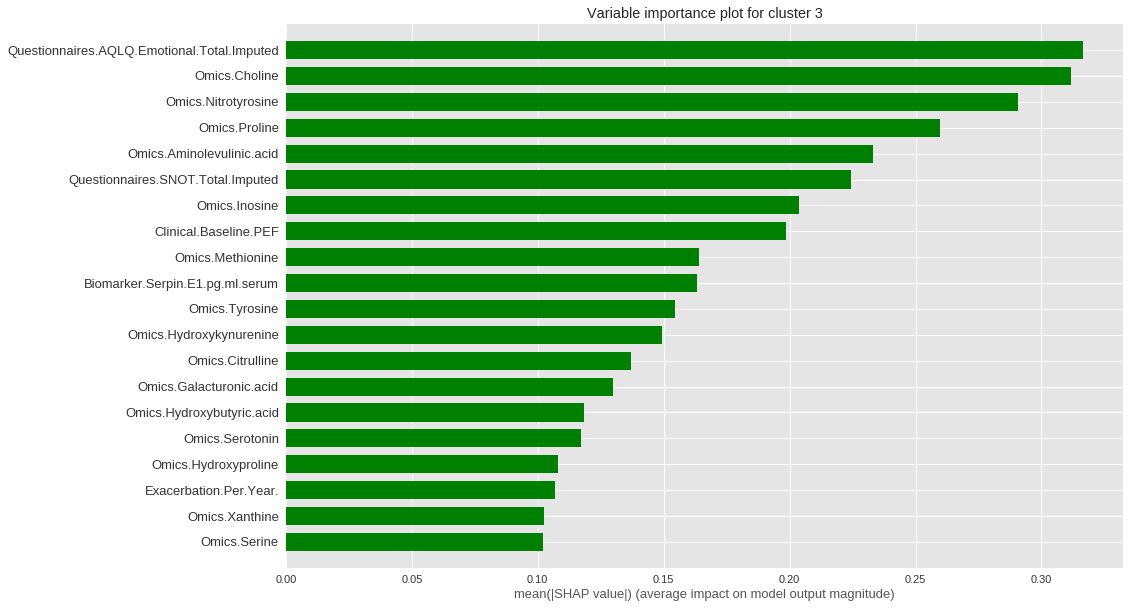

In [87]:
shap.summary_plot(shap_values_unsup_K4[2], df_unsup_copy_4, plot_type="bar", plot_size=(15, 10),color="green",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 3")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust3_K4unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 4

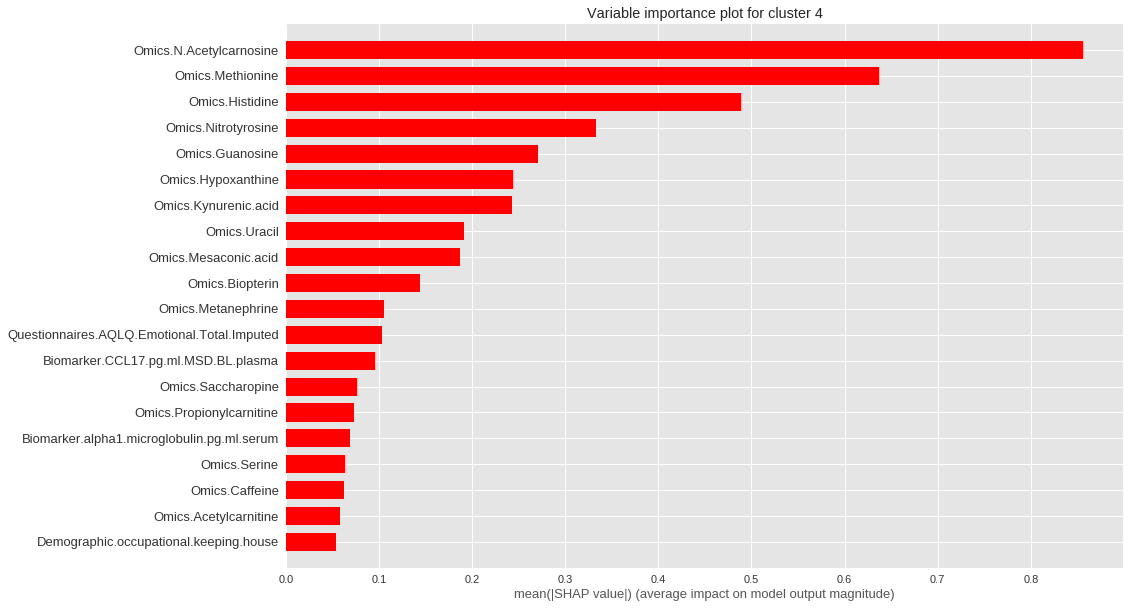

In [83]:
shap.summary_plot(shap_values_unsup_K4[3], df_unsup_copy_4, plot_type="bar", plot_size=(15, 10),color="red",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 4")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust4_K4unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

REDO ANALYSIS WITH K = 5

In [24]:
#From PCA viz, optimal number of K is 5, CH score using Cao method too.
#Run kprototypes with K=5
import random
random.seed(95)
style.use("ggplot")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

kproto_df_unsup_5 = KPrototypes(n_clusters= 5, init='Cao', n_jobs = 4)
cluster_df_unsup_5 = kproto_df_unsup_5.fit_predict(X_df_unsup_proto, categorical = cat_columns_df_unsup_proto)

# Print cluster centroids of the trained model.
print(kproto_df_unsup_5.cluster_centroids_)

# Print training statistics
print(kproto_df_unsup_5.cost_)
print(kproto_df_unsup_5.n_iter_)

[[-0.11566728 -0.14001255 -0.21294571 ... -0.07030177 -0.87934965
   0.30470877]
 [-0.06420597 -0.0128068   0.18607953 ... -0.07030177 -0.87934965
   0.30470877]
 [-0.20189333 -0.15184405 -0.21779187 ... -0.07030177 -0.87934965
   0.30470877]
 [ 0.20548471  0.19844591  0.13305375 ... -0.07030177 -0.87934965
   0.30470877]
 [ 0.07737959  0.03911855  0.16360516 ... -0.07030177 -0.87934965
   0.30470877]]
107796.90304819903
13


In [25]:
#Print count of each cluster
print(pd.Series(cluster_df_unsup_5).value_counts())

3    166
0    137
4    124
2    117
1     66
dtype: int64


In [26]:
#Get kproto_df_scale_cat labels as follow
kproto_df_unsup_labs_5 = kproto_df_unsup_5.labels_

In [27]:
#Make a copy of df_sup_proto and set the objects to category 
df_unsup_copy_5 = df_unsup_proto.copy()
for i in df_unsup_copy_5.select_dtypes(include='object'):
    df_unsup_copy_5[i] = df_unsup_copy_5[i].astype('category')

EVALUATION OF CLUSTERING METHOD BY CLASSIFICATION FOR K=5

In [28]:
#Use of LightGBM as my classifier because it handles categorical variables and because it is relatively fast to obtain shap values for the trained models.
clf_unsup_K5 = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_unsup_K5 = cross_val_score(clf_unsup_K5, df_unsup_copy_5, kproto_df_unsup_labs_5, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_unsup_K5)}')
#CV score of 0.8209 (less close to 1 but still pretty good) meaning that the observations are less grouped in meaningful and distinguishable clusters.

CV F1 score for K-Prototypes clusters is 0.8209624539237806


In [29]:
clf_unsup_K5.fit(df_unsup_copy_5, kproto_df_unsup_labs_5)

LGBMClassifier(colsample_by_tree=0.8)

In [30]:
explainer_unsup_K5 = shap.TreeExplainer(clf_unsup_K5)
shap_values_unsup_K5 = explainer_unsup_K5.shap_values(df_unsup_copy_5)

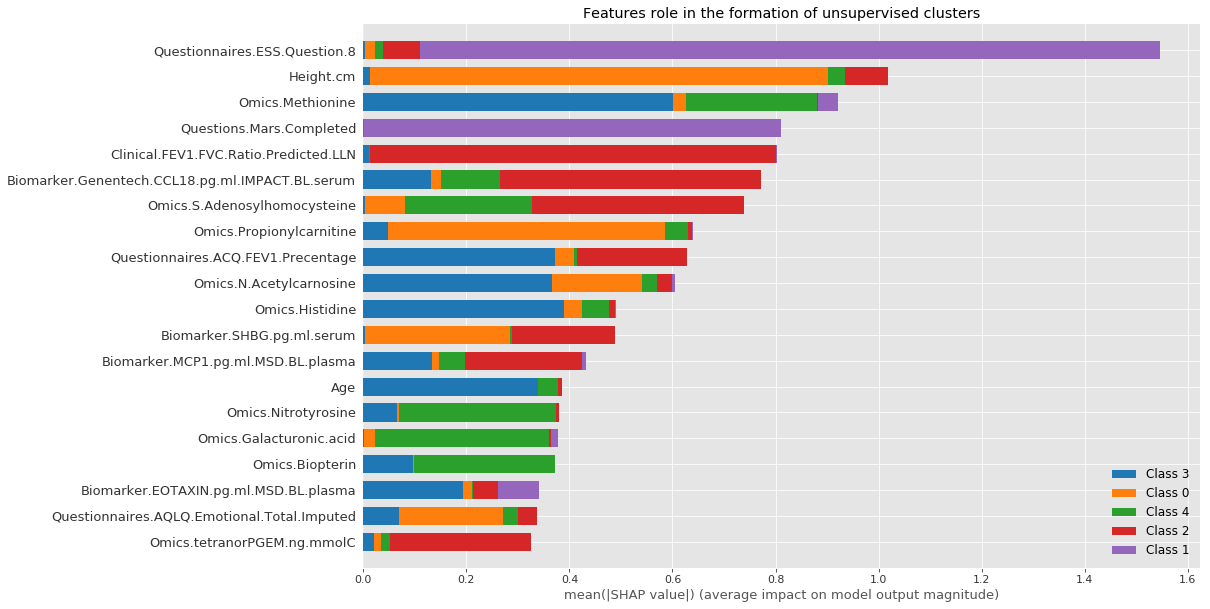

In [31]:
shap.summary_plot(shap_values_unsup_K5, df_unsup_copy_5, plot_type="bar", plot_size=(15, 10),color=plt.get_cmap("tab10"),show=False)
ax = plt.gca()
plt.title("Features role in the formation of unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_5_clusters_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 1

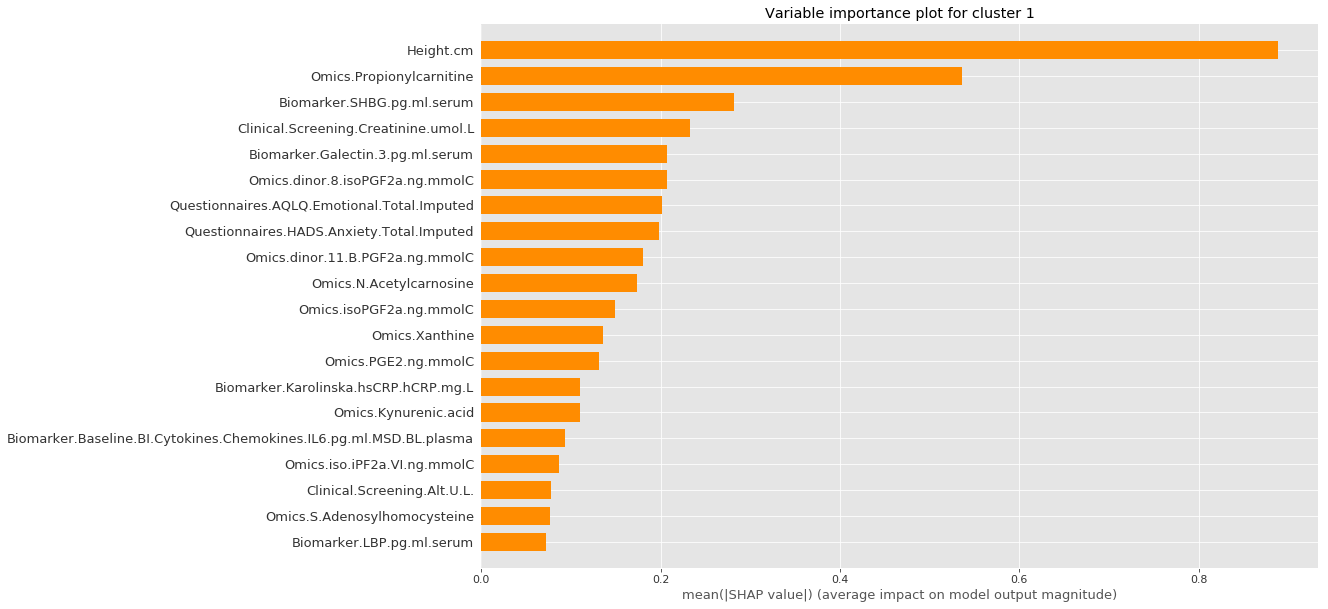

In [37]:
shap.summary_plot(shap_values_unsup_K5[0], df_unsup_copy_5, plot_type="bar", plot_size=(15, 10),color="darkorange",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 1")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust1_K5unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 2

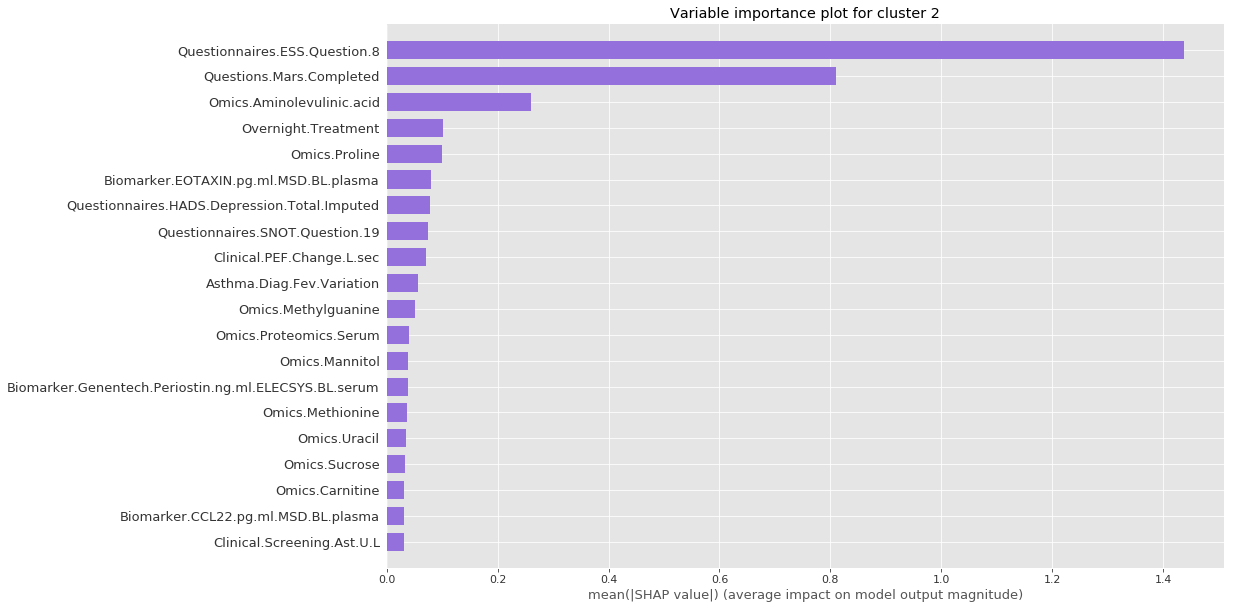

In [33]:
shap.summary_plot(shap_values_unsup_K5[1], df_unsup_copy_5, plot_type="bar", plot_size=(15, 10),color="mediumpurple",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 2")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust2_K5unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 3

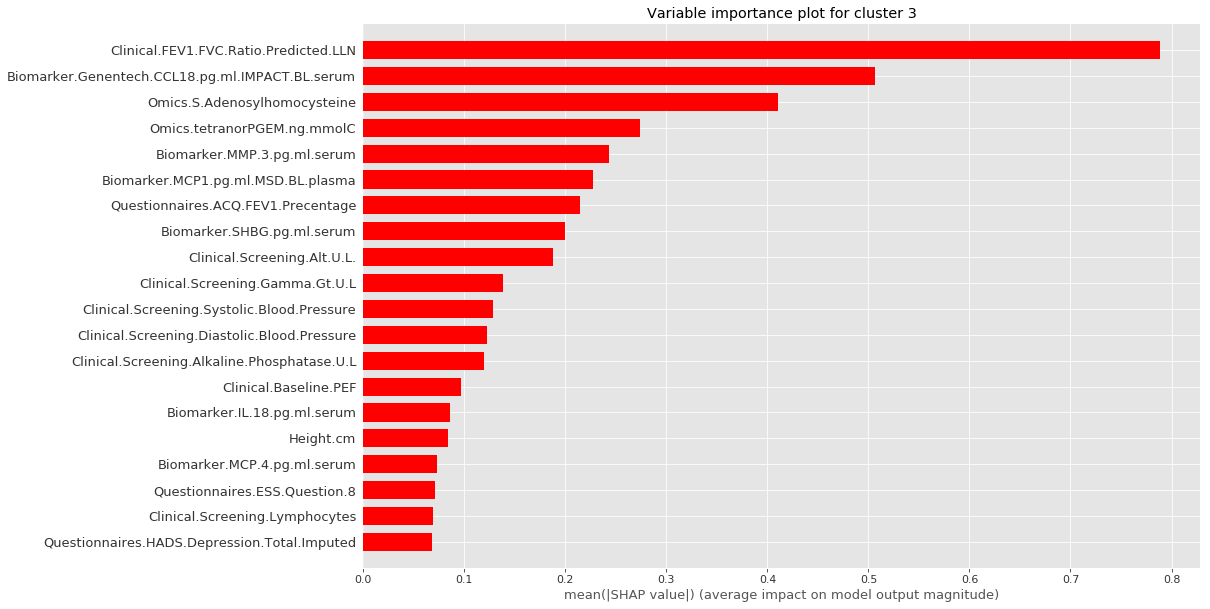

In [38]:
shap.summary_plot(shap_values_unsup_K5[2], df_unsup_copy_5, plot_type="bar", plot_size=(15, 10),color="red",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 3")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust3_K5unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 4

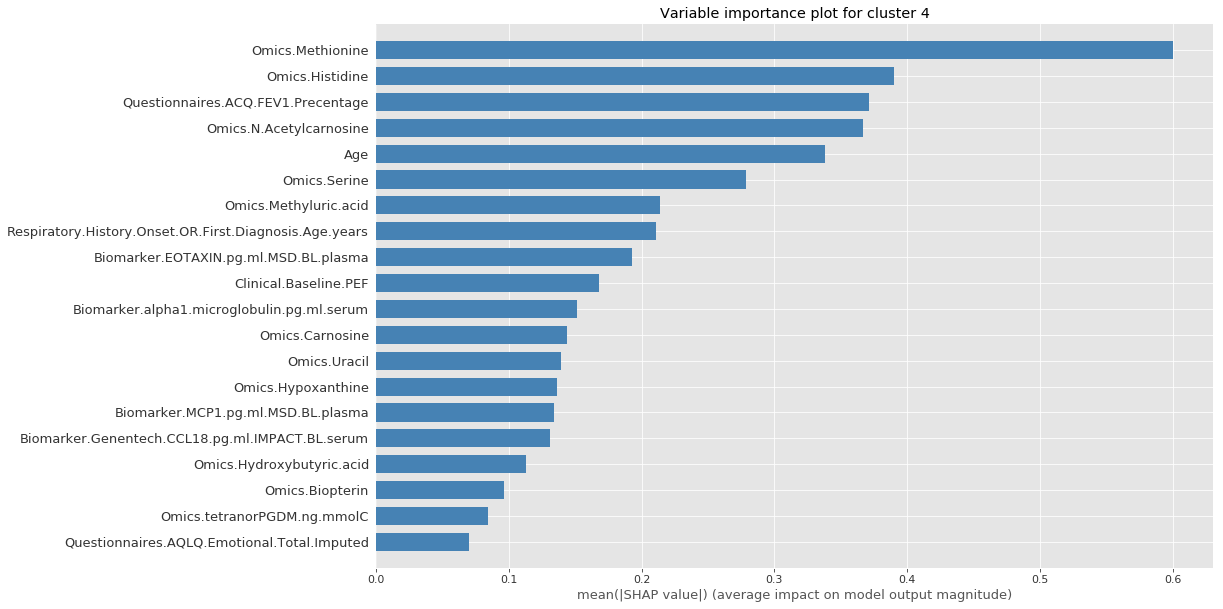

In [39]:
shap.summary_plot(shap_values_unsup_K5[3], df_unsup_copy_5, plot_type="bar", plot_size=(15, 10),color="steelblue",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 4")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust4_K5unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

SHAP PLOT CLUSTER 5

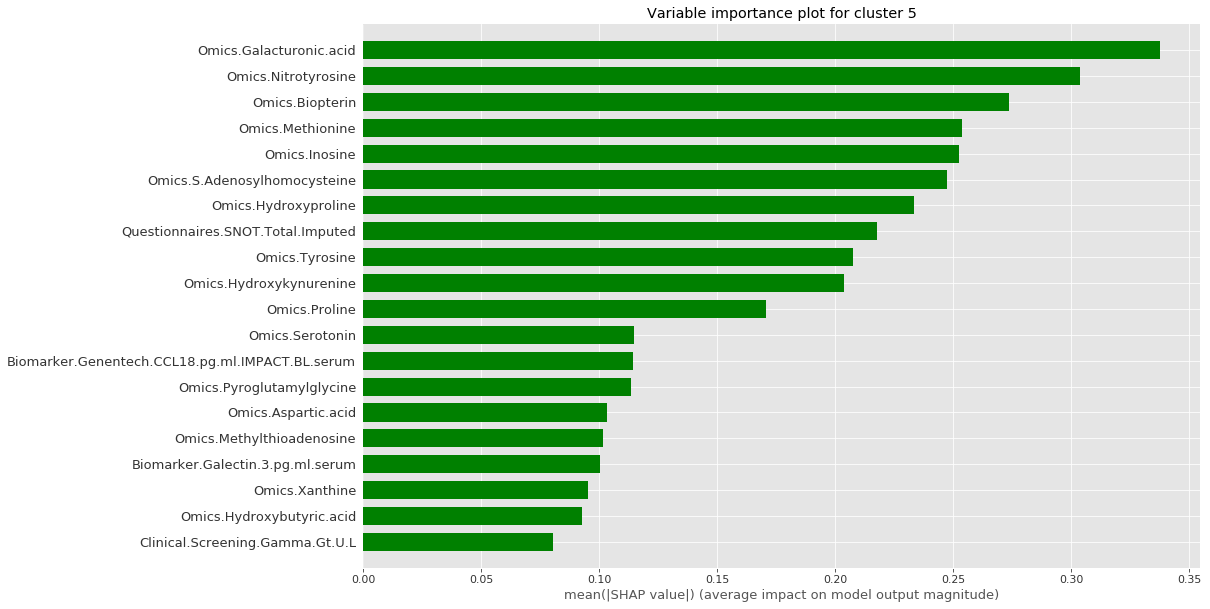

In [40]:
shap.summary_plot(shap_values_unsup_K5[4], df_unsup_copy_5, plot_type="bar", plot_size=(15, 10),color="green",show=False)
ax = plt.gca()
plt.title("Variable importance plot for cluster 5")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_UNSUP")
plt.savefig('shap_plot_clust5_K5unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

CROSSTABS - CLUSTER - OUTCOME

Relationship between Ks (Sup Clustering) and outcome (asthma severity)

In [42]:
combo_2_un = pd.crosstab(df_unsup['cluster_K_2'], df_unsup['cohort'])
combo_3_un = pd.crosstab(df_unsup['cluster_K_3'], df_unsup['cohort'])
combo_4_un = pd.crosstab(df_unsup['cluster_K_4'], df_unsup['cohort'])
combo_5_un = pd.crosstab(df_unsup['cluster_K_5'], df_unsup['cohort'])
combo_6_un = pd.crosstab(df_unsup['cluster_K_6'], df_unsup['cohort'])
combo_7_un = pd.crosstab(df_unsup['cluster_K_7'], df_unsup['cohort'])
combo_8_un = pd.crosstab(df_unsup['cluster_K_8'], df_unsup['cohort'])
combo_9_un = pd.crosstab(df_unsup['cluster_K_9'], df_unsup['cohort'])
combo_10_un = pd.crosstab(df_unsup['cluster_K_10'], df_unsup['cohort'])
combo_11_un = pd.crosstab(df_unsup['cluster_K_11'], df_unsup['cohort'])
combo_12_un = pd.crosstab(df_unsup['cluster_K_12'], df_unsup['cohort'])
combo_13_un = pd.crosstab(df_unsup['cluster_K_13'], df_unsup['cohort'])
combo_14_un = pd.crosstab(df_unsup['cluster_K_14'], df_unsup['cohort'])
combo_15_un = pd.crosstab(df_unsup['cluster_K_15'], df_unsup['cohort'])

K_2_Healthy_un = pd.crosstab(df_unsup['cluster_K_2'], df_unsup['Healthy'])
K_2_MildModerate_un = pd.crosstab(df_unsup['cluster_K_2'], df_unsup['MildModerate'])
K_2_Severe_un = pd.crosstab(df_unsup['cluster_K_2'], df_unsup['Severe'])
K_2_Severe_Smoker_un = pd.crosstab(df_unsup['cluster_K_2'], df_unsup['Severe_Smoker'])
K_2_Severe_asthma_un = pd.crosstab(df_unsup['cluster_K_2'], df_unsup['Severe_asthma'])

K_3_Healthy_un = pd.crosstab(df_unsup['cluster_K_3'], df_unsup['Healthy'])
K_3_MildModerate_un = pd.crosstab(df_unsup['cluster_K_3'], df_unsup['MildModerate'])
K_3_Severe_un = pd.crosstab(df_unsup['cluster_K_3'], df_unsup['Severe'])
K_3_Severe_Smoker_un = pd.crosstab(df_unsup['cluster_K_3'], df_unsup['Severe_Smoker'])
K_3_Severe_asthma_un = pd.crosstab(df_unsup['cluster_K_3'], df_unsup['Severe_asthma'])

K_5_Healthy_un = pd.crosstab(df_unsup['cluster_K_5'], df_unsup['Healthy'])
K_5_MildModerate_un = pd.crosstab(df_unsup['cluster_K_5'], df_unsup['MildModerate'])
K_5_Severe_un = pd.crosstab(df_unsup['cluster_K_5'], df_unsup['Severe'])
K_5_Severe_Smoker_un = pd.crosstab(df_unsup['cluster_K_5'], df_unsup['Severe_Smoker'])
K_5_Severe_asthma_un = pd.crosstab(df_unsup['cluster_K_5'], df_unsup['Severe_asthma'])

In [43]:
#Get percentages

K_2_Healthy_percentage_un = K_2_Healthy_un.div(K_2_Healthy_un.sum(axis=1),axis=0)*100
K_2_MildModerate_percentage_un = K_2_MildModerate_un.div(K_2_MildModerate_un.sum(axis=1),axis=0)*100
K_2_Severe_percentage_un = K_2_Severe_un.div(K_2_Severe_un.sum(axis=1),axis=0)*100
K_2_Severe_Smoker_percentage_un = K_2_Severe_Smoker_un.div(K_2_Severe_Smoker_un.sum(axis=1),axis=0)*100
K_2_Severe_asthma_percentage_un = K_2_Severe_asthma_un.div(K_2_Severe_asthma_un.sum(axis=1),axis=0)*100


K_5_Healthy_percentage_un = K_5_Healthy_un.div(K_5_Healthy_un.sum(axis=1),axis=0)*100
K_5_MildModerate_percentage_un = K_5_MildModerate_un.div(K_5_MildModerate_un.sum(axis=1),axis=0)*100
K_5_Severe_percentage_un = K_5_Severe_un.div(K_5_Severe_un.sum(axis=1),axis=0)*100
K_5_Severe_Smoker_percentage_un = K_5_Severe_Smoker_un.div(K_5_Severe_Smoker_un.sum(axis=1),axis=0)*100
K_5_Severe_asthma_percentage_un = K_5_Severe_asthma_un.div(K_5_Severe_asthma_un.sum(axis=1),axis=0)*100

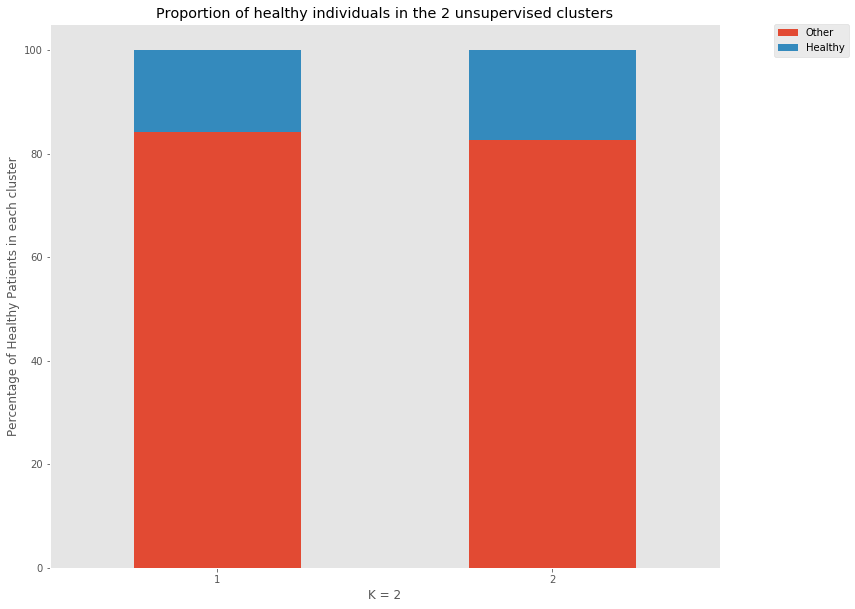

In [44]:
K_2_Healthy_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True,)
plt.grid(b=None)
plt.xlabel('K = 2')
plt.ylabel('Percentage of Healthy Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of healthy individuals in the 2 unsupervised clusters")
plt.legend(["Other", "Healthy"],bbox_to_anchor=(1.2,1.01))
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_2_Healthy_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

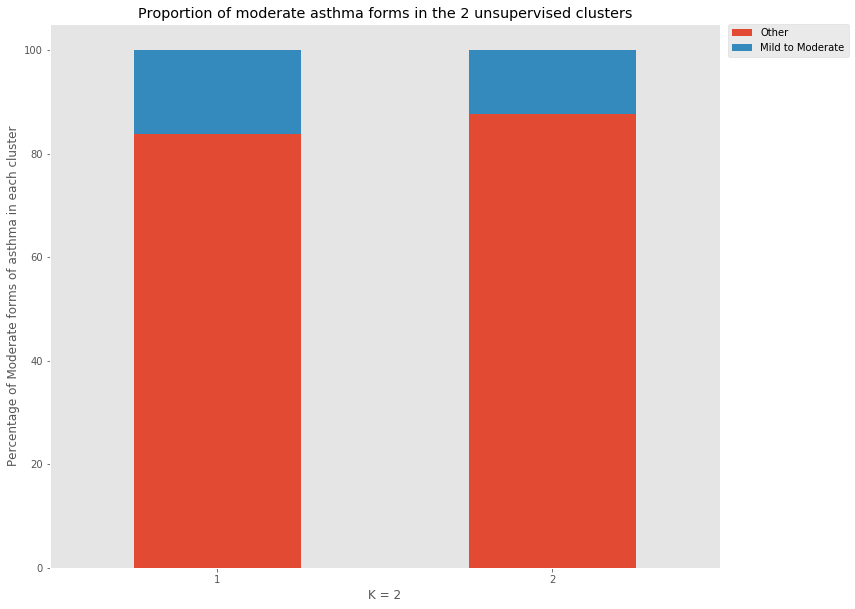

In [45]:
K_2_MildModerate_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Mild to Moderate"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 2')
plt.ylabel('Percentage of Moderate forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of moderate asthma forms in the 2 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_2_MildModerate_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

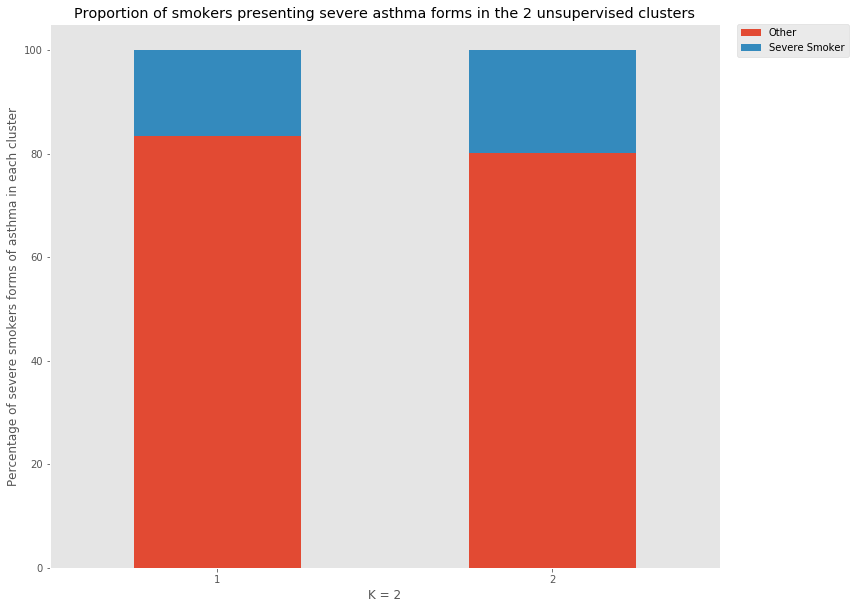

In [46]:
K_2_Severe_Smoker_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Severe Smoker"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 2')
plt.ylabel('Percentage of severe smokers forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of smokers presenting severe asthma forms in the 2 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_2_Severe_Smoker_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

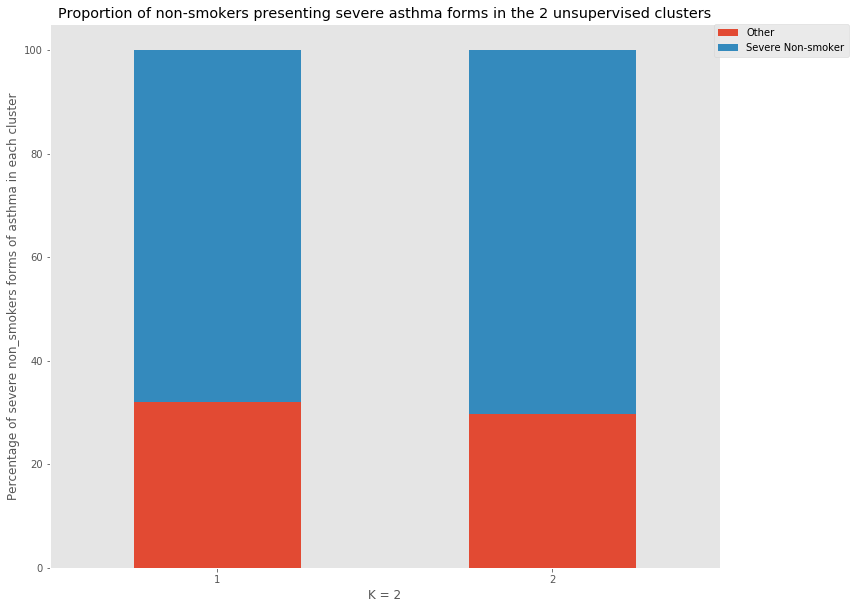

In [47]:
K_2_Severe_asthma_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Severe Non-smoker"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 2')
plt.ylabel('Percentage of severe non_smokers forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of non-smokers presenting severe asthma forms in the 2 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_2_Severe_asthma_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

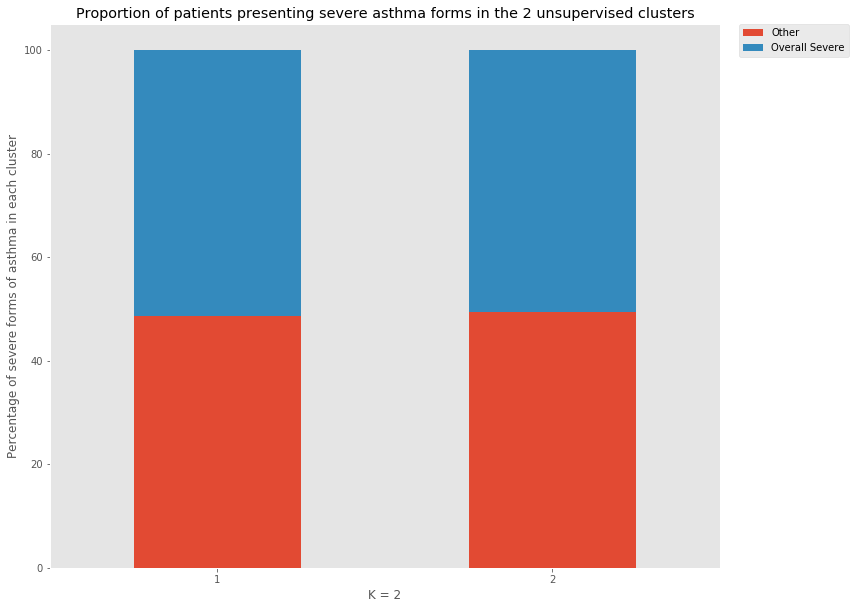

In [48]:
K_2_Severe_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Overall Severe"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 2')
plt.ylabel('Percentage of severe forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of patients presenting severe asthma forms in the 2 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_2_Severe_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

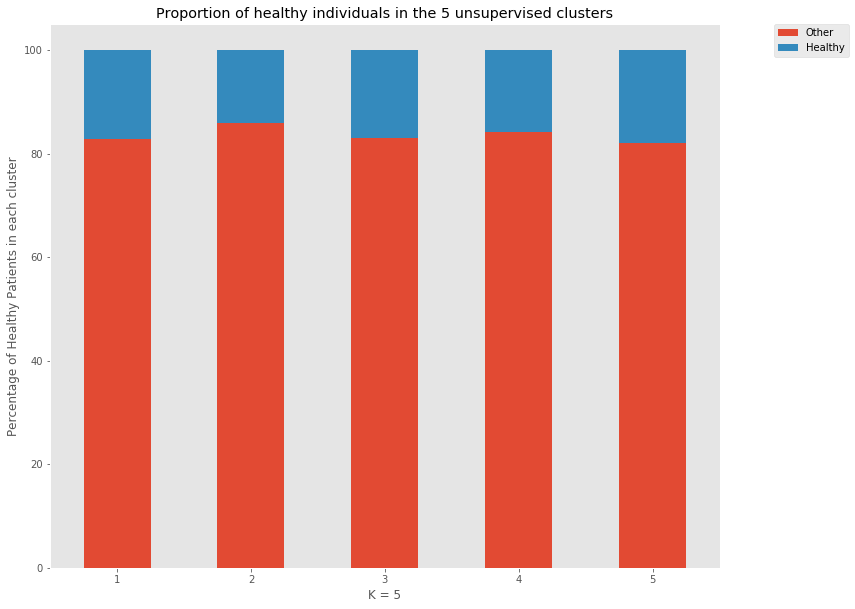

In [49]:
K_5_Healthy_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True,)
plt.grid(b=None)
plt.xlabel('K = 5')
plt.ylabel('Percentage of Healthy Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of healthy individuals in the 5 unsupervised clusters")
plt.legend(["Other", "Healthy"],bbox_to_anchor=(1.2,1.01))
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_5_Healthy_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

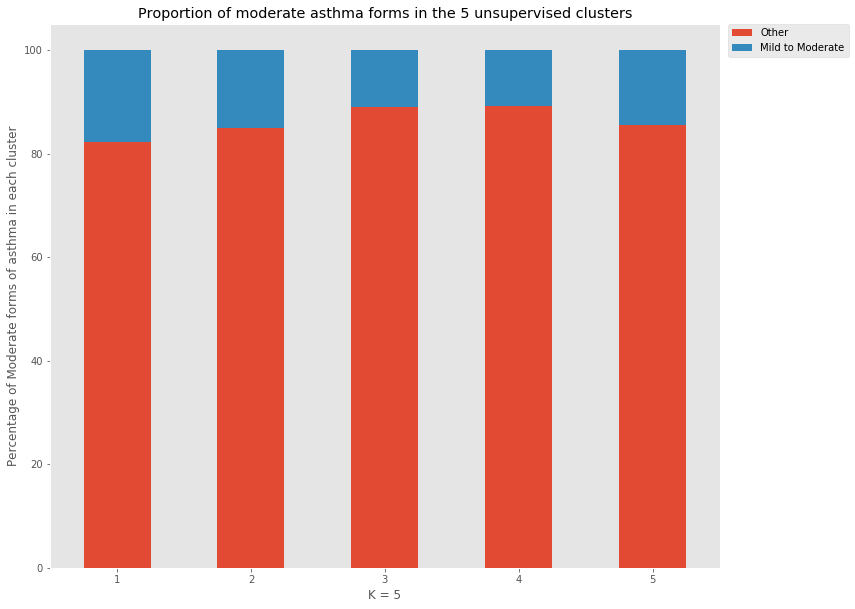

In [50]:
K_5_MildModerate_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Mild to Moderate"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 5')
plt.ylabel('Percentage of Moderate forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of moderate asthma forms in the 5 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_5_MildModerate_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

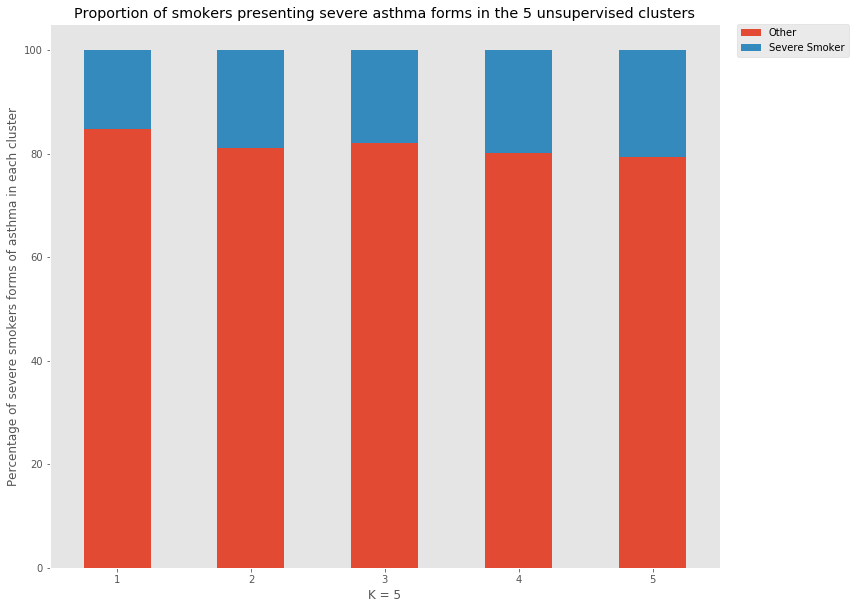

In [51]:
K_5_Severe_Smoker_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Severe Smoker"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 5')
plt.ylabel('Percentage of severe smokers forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of smokers presenting severe asthma forms in the 5 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_5_Severe_Smoker_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

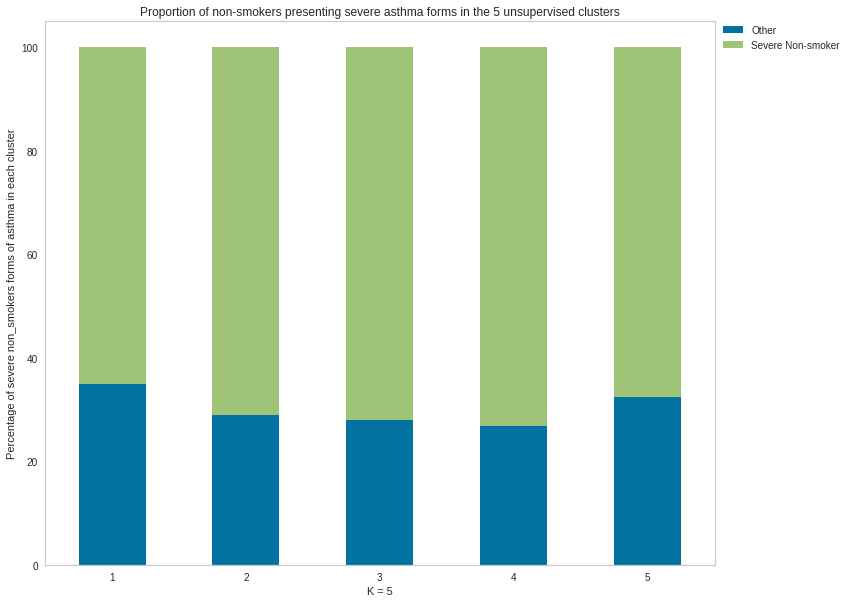

In [68]:
K_5_Severe_asthma_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Severe Non-smoker"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 5')
plt.ylabel('Percentage of severe non_smokers forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of non-smokers presenting severe asthma forms in the 5 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_5_Severe_asthma_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

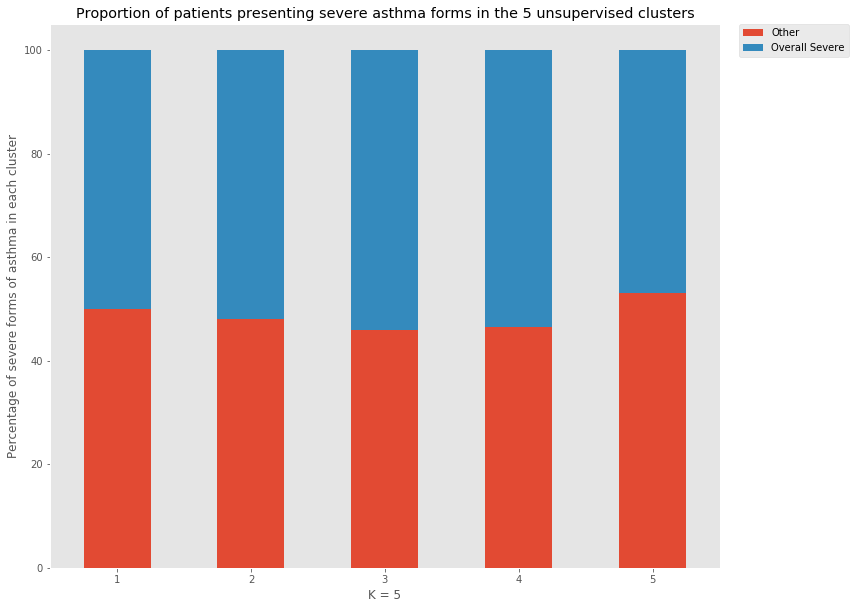

In [53]:
K_5_Severe_percentage_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(["Other", "Overall Severe"],bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 5')
plt.ylabel('Percentage of severe forms of asthma in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Proportion of patients presenting severe asthma forms in the 5 unsupervised clusters")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K_5_Severe_unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

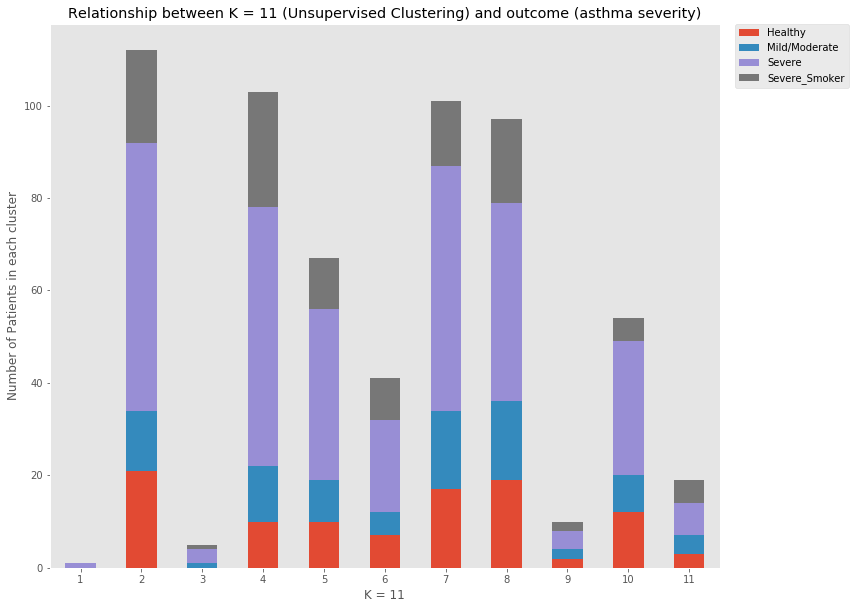

In [54]:
combo_11_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_11_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 11')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 11 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K11unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

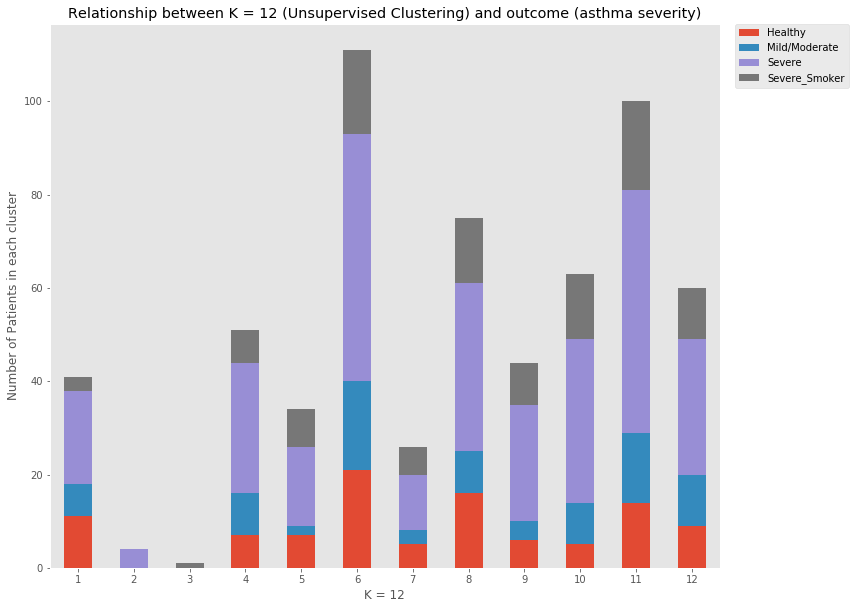

In [55]:
combo_12_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_12_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 12')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 12 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K12unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

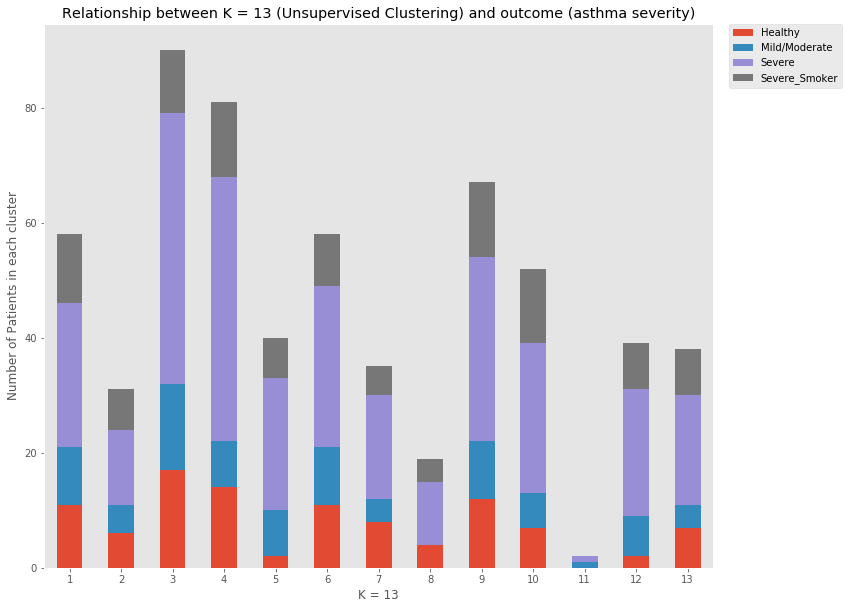

In [56]:
combo_13_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_13_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 13')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 13 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K13unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

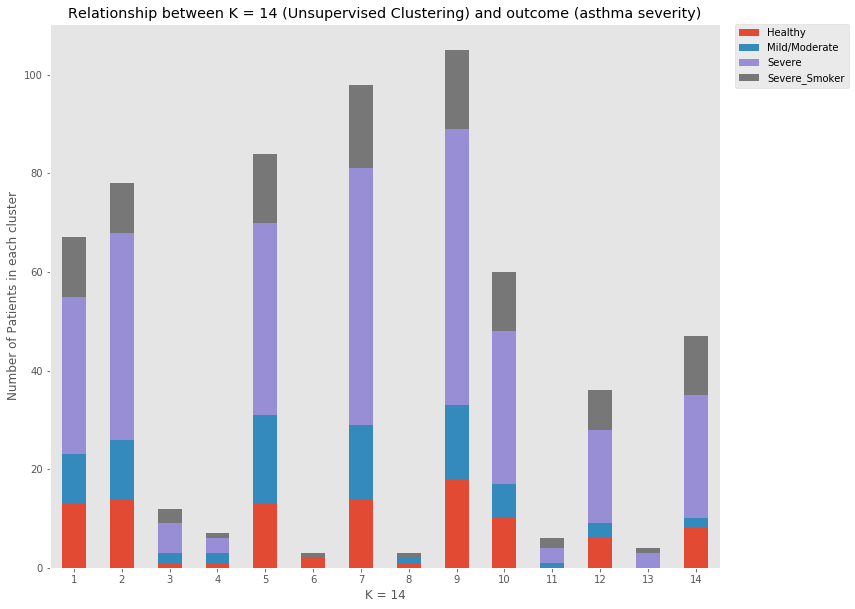

In [57]:
combo_14_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_14_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 14')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 14 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K14unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

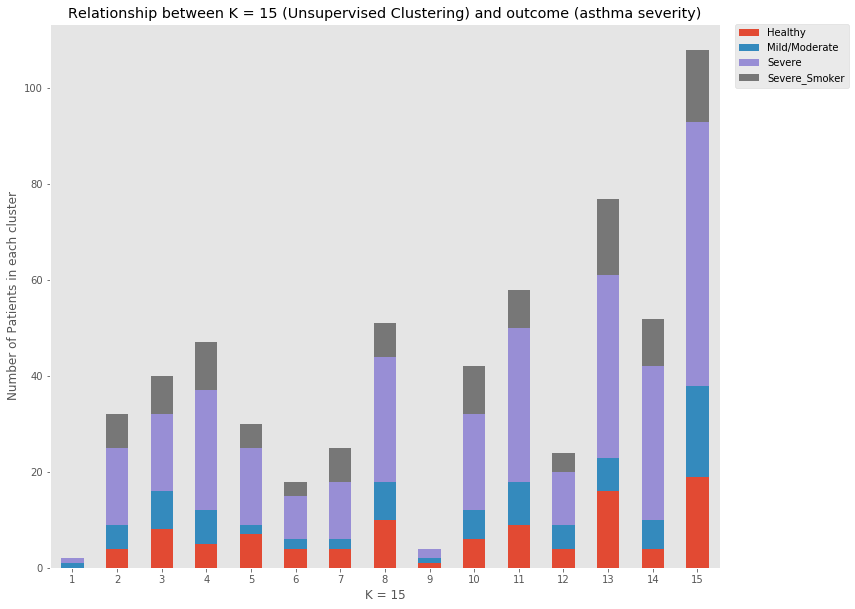

In [58]:
combo_15_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_15_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 15')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 15 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K15unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

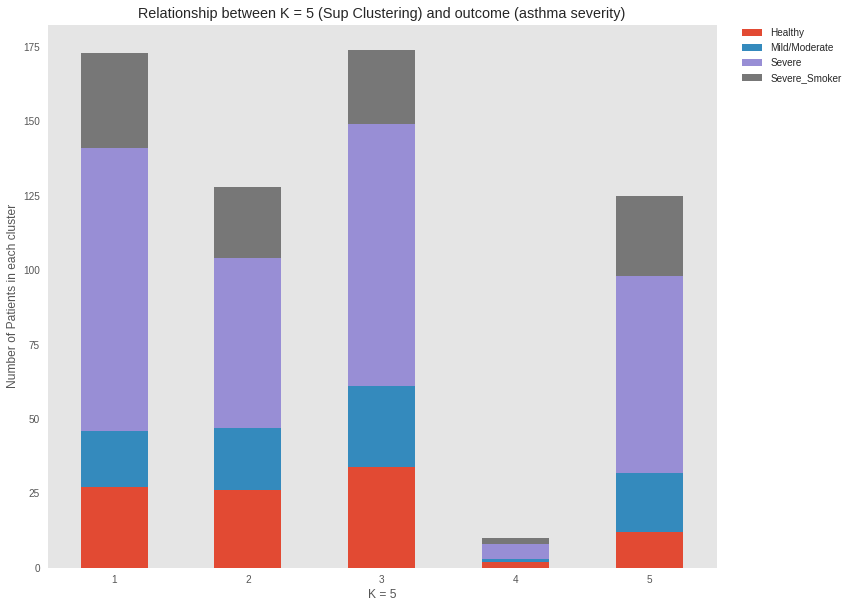

In [66]:
combo_5.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_5.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 5')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 5 (Sup Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs")
plt.savefig('crosstab_K5sup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

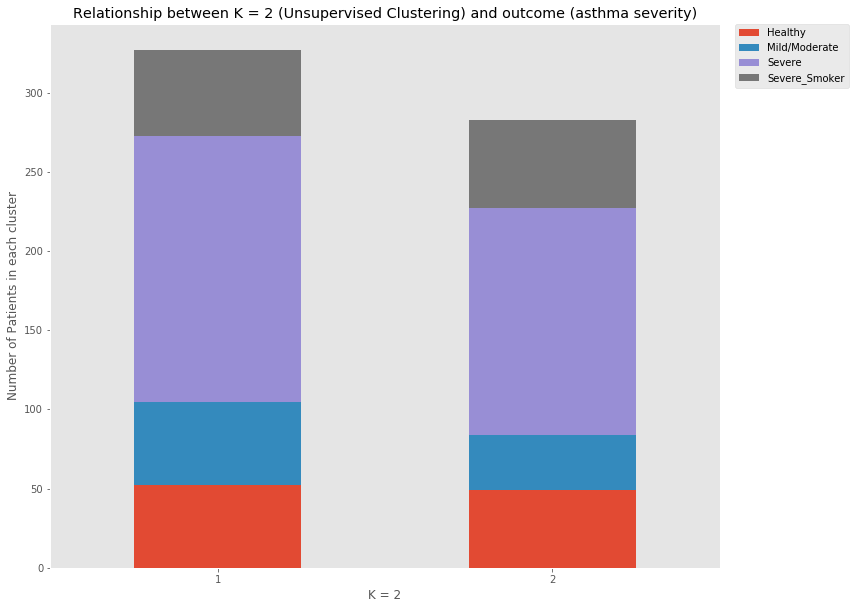

In [59]:
combo_2_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_2_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 2')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 2 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K2unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

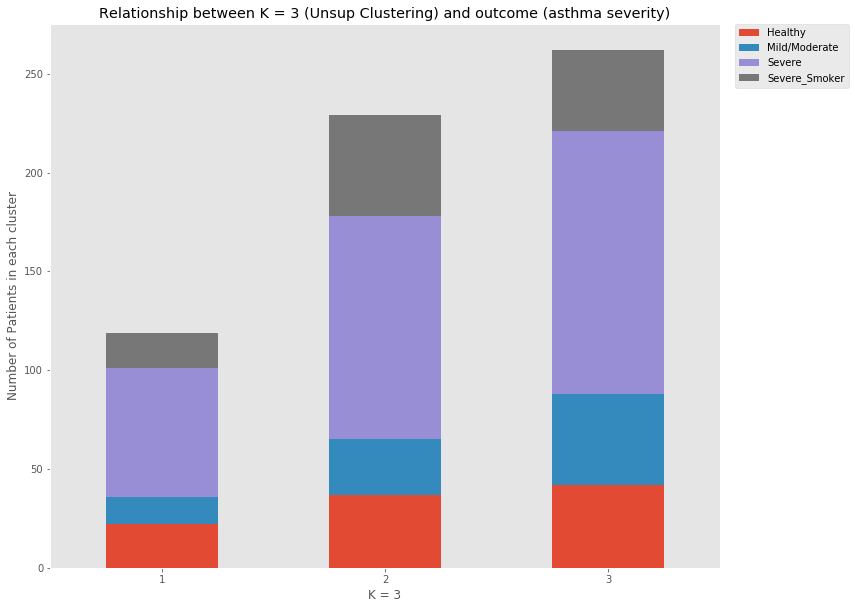

In [60]:
combo_3_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_3_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 3')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 3 (Unsup Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K3unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

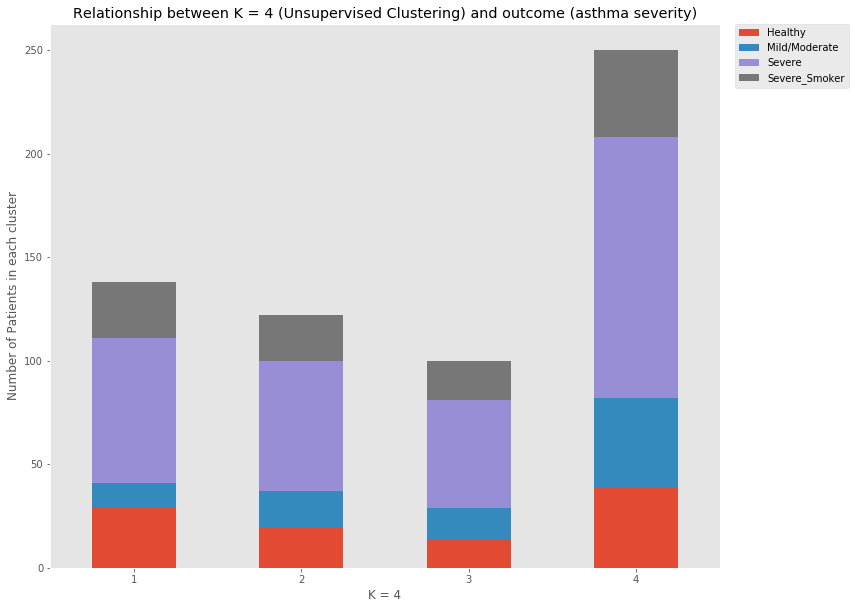

In [61]:
combo_4_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_4_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 4')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 4 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K4unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

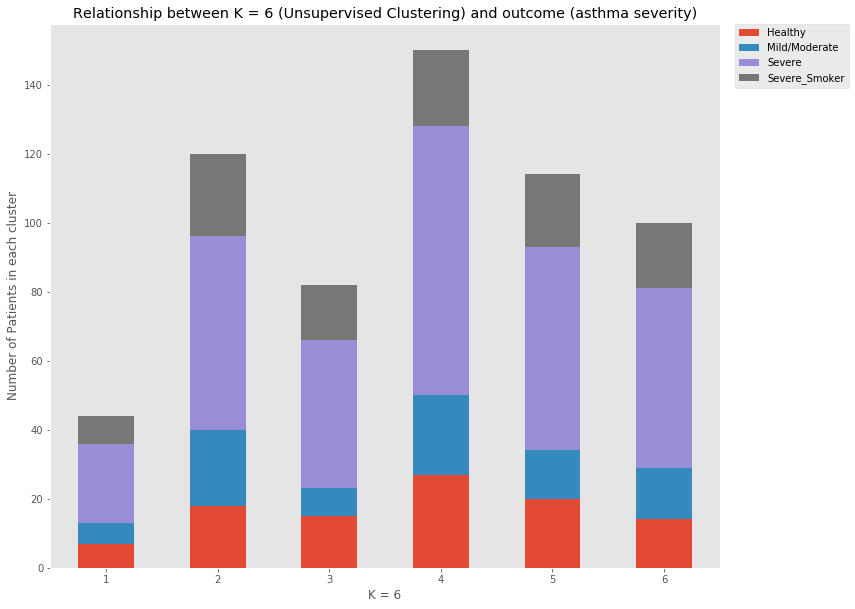

In [62]:
combo_6_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_6_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 6')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 6 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K6unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

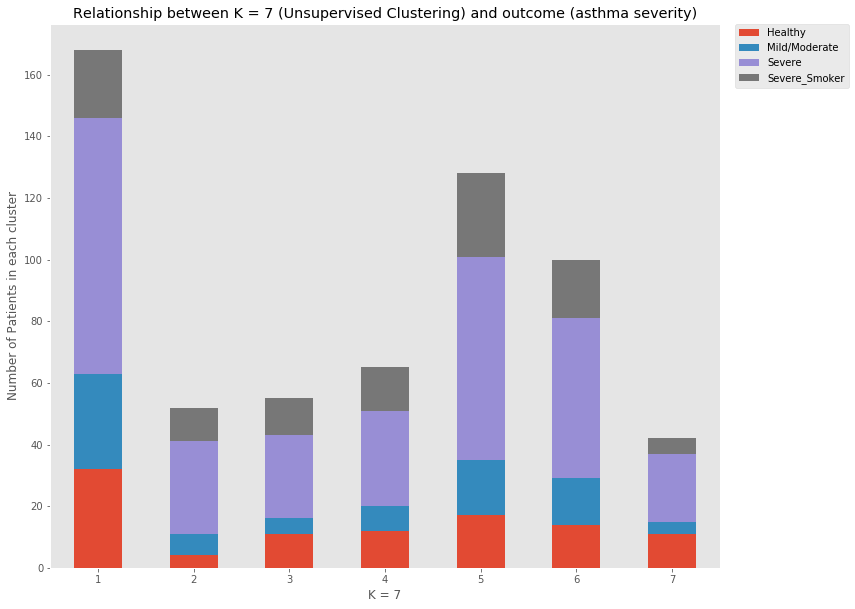

In [63]:
combo_7_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_7_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 7')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 7 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K7unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

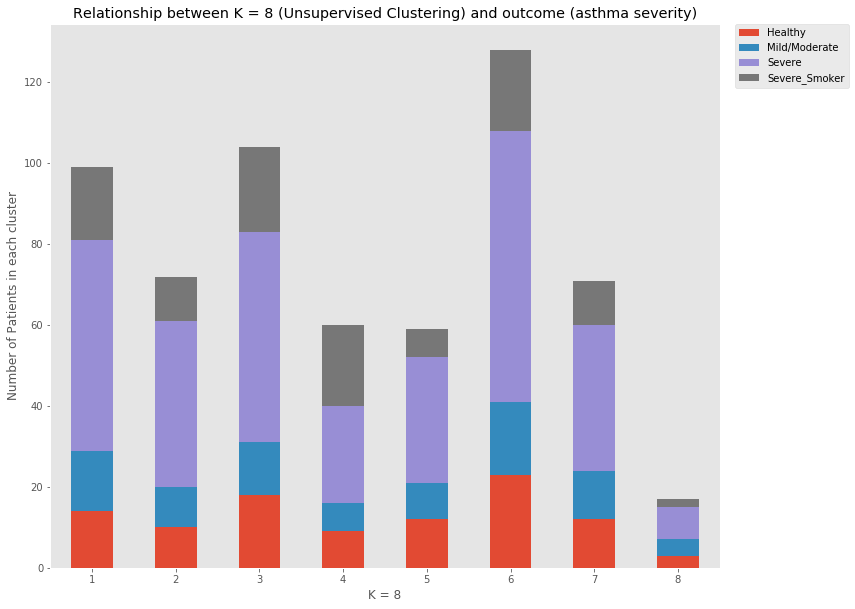

In [64]:
combo_8_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_8_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 8')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 8 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K8unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

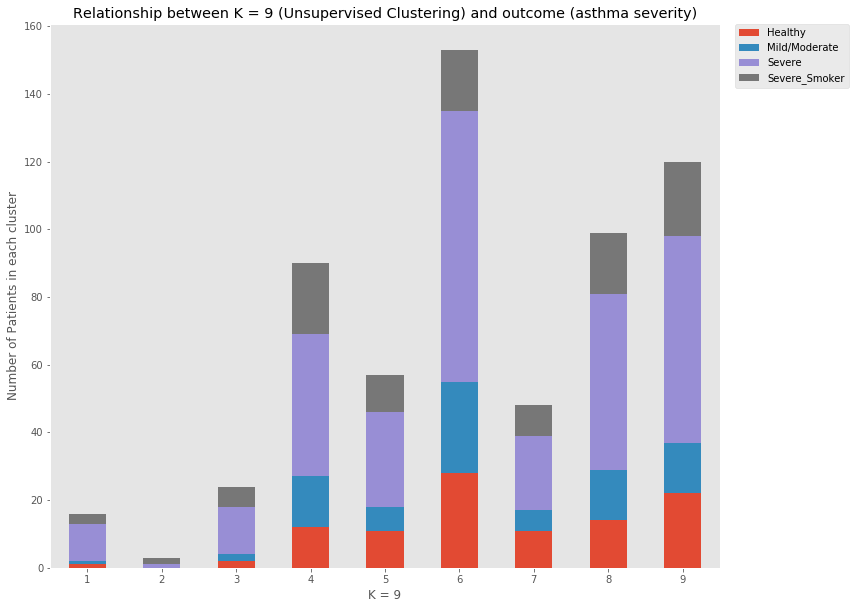

In [65]:
combo_9_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_9_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 9')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 9 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K9unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

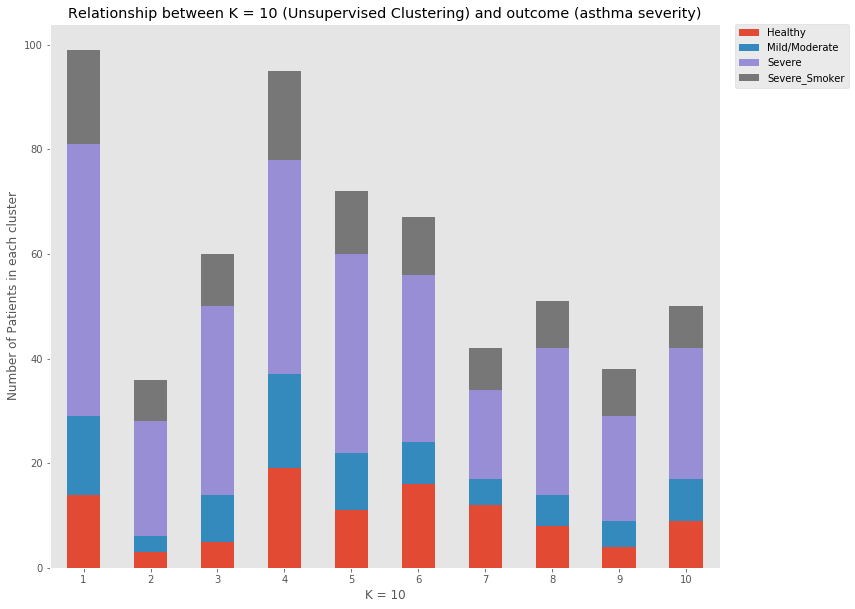

In [66]:
combo_10_un.plot(kind='bar', figsize = (12,10),  stacked=True)
plt.legend(combo_10_un.columns,bbox_to_anchor=(1.2,1.01))
plt.grid(b=None)
plt.xlabel('K = 10')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)
plt.title("Relationship between K = 10 (Unsupervised Clustering) and outcome (asthma severity)")
import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/crosstabs_unsup")
plt.savefig('crosstab_K10unsup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

STOP THERE

NOT USED AS OPTIMAL Ks

Relationship between K = 3 (Sup Clustering) and outcome (asthma severity)

In [53]:
combo_3 = pd.crosstab(df_sup['cluster_K_3'], df_sup['cohort'])

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

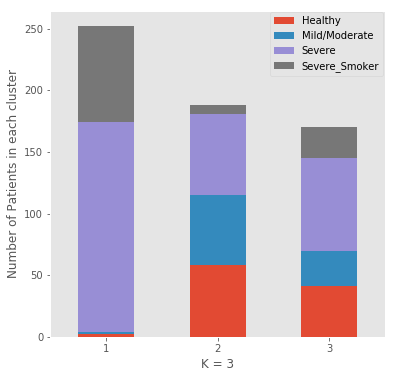

In [54]:
combo_3.plot(kind='bar', figsize = (6,6),  stacked=True)
plt.legend(combo_3.columns,bbox_to_anchor=(1.01,1.01))
plt.grid(b=None)
plt.xlabel('K = 3')
plt.ylabel('Number of Patients in each cluster')
degrees = 0
plt.xticks(rotation=degrees)

Relationship between K = 4 (Sup Clustering) and outcome (asthma severity)

In [56]:
combo_4 = pd.crosstab(df_sup['cluster_K_4'], df_sup['cohort'])

SHAP PLOT CLUSTER 3

In [51]:
shap.summary_plot(shap_values_sup_K11[2], df_sup_copy, plot_type="bar", plot_size=(15, 10),color = "orange",show=False)
ax = plt.gca()
plt.title("Feature importance plot for supervised cluster 3")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_SUP")
plt.savefig('shap_plot_clust3_sup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

IndexError: list index out of range

SHAP PLOT CLUSTER 4

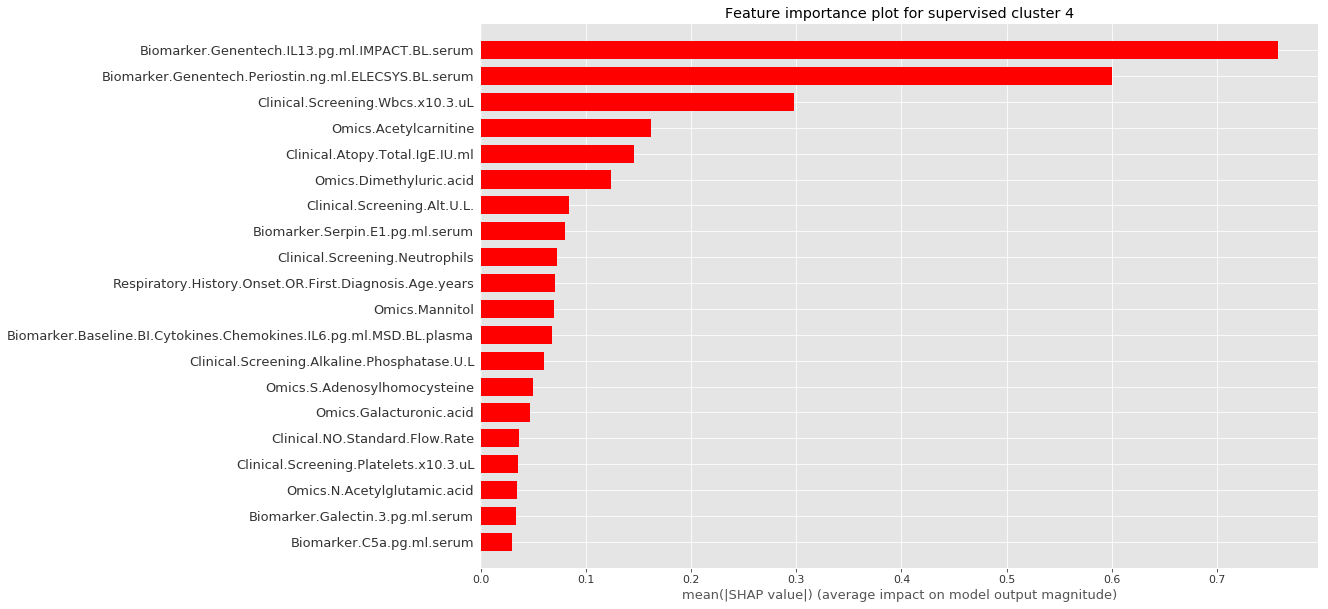

In [32]:
shap.summary_plot(shap_values_sup_K4[3], df_sup_copy, plot_type="bar", plot_size=(15, 10),color = "red",show=False)
ax = plt.gca()
plt.title("Feature importance plot for supervised cluster 4")
#import os
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/SHAP_SUP")
plt.savefig('shap_plot_clust4_sup.pdf',format='pdf', dpi=1000, bbox_inches='tight')

APPEND CLUSTERS RESULTS TO DF_SUP FOR K=4

In [35]:
df_sup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Columns: 119 entries, Unnamed: 0 to cluster_K_2
dtypes: float64(102), int64(3), object(14)
memory usage: 567.2+ KB


In [40]:
df_sup.head(5)

,Unnamed: 0,Biomarker.C5a.pg.ml.serum,Biomarker.CD40L.pg.ml.serum,Biomarker.DPPIV.pg.ml.serum,Biomarker.Galectin.3.pg.ml.serum,Biomarker.IL.18.pg.ml.serum,Biomarker.IL.1alpha.pg.ml.serum,Biomarker.IL.6Ralpha.pg.ml.serum,Biomarker.LBP.pg.ml.serum,Biomarker.MCP.4.pg.ml.serum,Biomarker.MMP.3.pg.ml.serum,Biomarker.RAGE.pg.ml.serum,Biomarker.SHBG.pg.ml.serum,Biomarker.Serpin.E1.pg.ml.serum,Biomarker.alpha1.microglobulin.pg.ml.serum,Biomarker.CCL17.pg.ml.MSD.BL.plasma,Biomarker.EOTAXIN.pg.ml.MSD.BL.plasma,Biomarker.Baseline.BI.Cytokines.Chemokines.IL6.pg.ml.MSD.BL.plasma,Biomarker.MCP1.pg.ml.MSD.BL.plasma,Biomarker.MIP1b.pg.ml.MSD.BL.plasma,Biomarker.TNFa.pg.ml.MSD.BL.plasma,Biomarker.Genentech.CCL18.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.IL13.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.Periostin.ng.ml.ELECSYS.BL.serum,Biomarker.Karolinska.hsCRP.hCRP.mg.L,Clinical.Atopy.Total.IgE.IU.ml,Clinical.NO.Standard.Flow.Rate,Clinical.Screening.Albumin.g.dL,Clinical.Screening.Alkaline.Phosphatase.U.L,Clinical.Screening.Alt.U.L.,Clinical.Screening.Ast.U.L,Clinical.Screening.Blood.Urea.Nitrogen.mg.dL,Clinical.Screening.Creatinine.umol.L,Clinical.Screening.Gamma.Gt.U.L,Clinical.Screening.Lymphocytes,Clinical.Screening.Monocytes,Clinical.Screening.Neutrophils,Clinical.Screening.Platelets.x10.3.uL,Clinical.Screening.Sodium.mmol.L,Clinical.Screening.Total.Bilirubin.umol.L,Clinical.Screening.Total.Protein.g.dL,Clinical.Screening.Wbcs.x10.3.uL,Clinical.Screening.eosinophils.x10.3.uL,Clinical.Screening.lymphocytes.x10.3.uL,Clinical.FEF.25.75.Absolute.Change.L.sec,Clinical.FEV1.FVC.Ratio.Predicted.LLN,Clinical.FVC.Absolute.Change.L,Clinical.Baseline.PEF,Clinical.Screening.Diastolic.Blood.Pressure,Clinical.Screening.Heart.Rate,Clinical.Screening.Respiratory.Rate,Clinical.Screening.Systolic.Blood.Pressure,Demographic.Age,Exacerbation.Per.Year.,Omics.dehydroTXB2.ng.mmolC,Omics.dinor.11.B.PGF2a.ng.mmolC,Omics.dinor.8.isoPGF2a.ng.mmolC,Omics.dinor.TXB2.ng.mmolC,Omics.isoPGF2a.ng.mmolC,Omics.LTE4.ng.mmolC,Omics.PGF2a.ng.mmolC,Omics.tetranorPGDM.ng.mmolC,Omics.tetranorPGEM.ng.mmolC,Omics.Trimethyluric.acid,Omics.Dimethyluric.acid,Omics.Methyluric.acid,Omics.Methylxanthine,Omics.Acetylamino.6.formylamino.3.methyluracil,Omics.Acetylcarnitine,Omics.Carnitine,Omics.Galacturonic.acid,Omics.Glutamine,Omics.Guanine,Omics.Histidine,Omics.Kynurenic.acid,Omics.Maltose,Omics.Mannitol,Omics.Methionine,Omics.Methylthioadenosine,Omics.N.Acetylcarnosine,Omics.N.Acetylglutamic.acid,Omics.N.Acetylputrescine,Omics.N.Methyl.D.aspartic.acid,Omics.N.Methylhistamine,Omics.Pipecolic.acid,Omics.Propionylcarnitine,Omics.S.Adenosylhomocysteine,Omics.Saccharopine,Omics.Sarcosine,Omics.Serine,Omics.Serotonin,Omics.Sucrose,Omics.Uracil,Omics.Xylose,Questionnaires.ACQ.FEV1.Precentage,Questionnaires.AQLQ.Emotional.Total.Imputed,Questionnaires.ESS.Total.Imputed,Questionnaires.HADS.Anxiety.Total.Imputed,Questionnaires.HADS.Depression.Total.Imputed,Questionnaires.SNOT.Total.Imputed,Body.Mass.Index.kg.m2,Height.cm,Respiratory.History.Onset.OR.First.Diagnosis.Age.years,Omics.Proteomics.Serum,Questions.Screening.Asthma.Father,Questions.Screening.Hay.Fever.Mother,Questions.Screening.Inflammatory.Disease.Father,Hay.Fever.Diagnosed,Non.Allergic.Rhinitis.Diagnosed,Parental.Asthma,Clinical.Screening.Haematology.Not.Done,cohort,cluster_K_6,Healthy,MildModerate,Severe,Severe_Smoker,Severe_asthma,cluster_K_2
0,A_005,0.229508,0.333360,0.517148,0.350924,0.192343,0.500000,0.347316,0.303933,0.243902,0.051612,0.361961,0.082350,0.265279,0.440303,0.051313,0.107015,0.0,0.414110,0.084239,0.50,0.256313,0.0,0.296610,0.000000,0.038614,0.143564,0.000000,0.252101,0.189189,0.160584,0.250000,0.276786,0.477444,0.666667,0.266667,0.322581,0.246231,0.666667,0.147059,0.8,0.3125,0,0.50,0.202703,0.384615,0.455882,0.689655,0.523810,0.120482,0.157895,0.813084,0.750000,0.0000,0.017241,0.112903,0.289788,0.027431,0.179348,0.028436,0.289796,0.128900,0.111971,0.273604,0.280313,0.053317,0.541940,0.108712,0.019973,0.084073,0.304488,0

In [39]:
#Rename cluster column with cluster_K_6
df_sup.rename(columns = {'cluster':'cluster_K_6'}, inplace = True)

In [41]:
#Set index aside (Patient ID) as we don't want to include it in K-prototypes (done already)
ID = df_sup['Unnamed: 0'].to_list()
ID= np.asarray(ID)
len(ID)

610

In [42]:
#Append the cluster results for K=4 and save dataframe for future visualization
clust_dict={}
clust=[]
for s, c in zip(ID, cluster_df_sup):
    clust_dict[s]=c
    clust.append(c)
df_sup['cluster_K_4']=clust
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Dataframes/Final")
df_sup.to_csv("df_sup_clusters_attached_viz.csv")

VISUALIZATION OF THE CLUSTERS

In [46]:
#Import dataset for viz
df_viz_sup = pd.read_csv('/rds/general/user/md2620/home/asthma/Malo/Dataframes/Final/df_sup_clusters_attached_viz.csv', low_memory=False)

In [49]:
df_viz_sup.head(5)

,Unnamed: 0,X,Biomarker.C5a.pg.ml.serum,Biomarker.CD40L.pg.ml.serum,Biomarker.DPPIV.pg.ml.serum,Biomarker.Galectin.3.pg.ml.serum,Biomarker.IL.18.pg.ml.serum,Biomarker.IL.1alpha.pg.ml.serum,Biomarker.IL.6Ralpha.pg.ml.serum,Biomarker.LBP.pg.ml.serum,Biomarker.MCP.4.pg.ml.serum,Biomarker.MMP.3.pg.ml.serum,Biomarker.RAGE.pg.ml.serum,Biomarker.SHBG.pg.ml.serum,Biomarker.Serpin.E1.pg.ml.serum,Biomarker.alpha1.microglobulin.pg.ml.serum,Biomarker.CCL17.pg.ml.MSD.BL.plasma,Biomarker.EOTAXIN.pg.ml.MSD.BL.plasma,Biomarker.Baseline.BI.Cytokines.Chemokines.IL6.pg.ml.MSD.BL.plasma,Biomarker.MCP1.pg.ml.MSD.BL.plasma,Biomarker.MIP1b.pg.ml.MSD.BL.plasma,Biomarker.TNFa.pg.ml.MSD.BL.plasma,Biomarker.Genentech.CCL18.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.IL13.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.Periostin.ng.ml.ELECSYS.BL.serum,Biomarker.Karolinska.hsCRP.hCRP.mg.L,Clinical.Atopy.Total.IgE.IU.ml,Clinical.NO.Standard.Flow.Rate,Clinical.Screening.Albumin.g.dL,Clinical.Screening.Alkaline.Phosphatase.U.L,Clinical.Screening.Alt.U.L.,Clinical.Screening.Ast.U.L,Clinical.Screening.Blood.Urea.Nitrogen.mg.dL,Clinical.Screening.Creatinine.umol.L,Clinical.Screening.Gamma.Gt.U.L,Clinical.Screening.Lymphocytes,Clinical.Screening.Monocytes,Clinical.Screening.Neutrophils,Clinical.Screening.Platelets.x10.3.uL,Clinical.Screening.Sodium.mmol.L,Clinical.Screening.Total.Bilirubin.umol.L,Clinical.Screening.Total.Protein.g.dL,Clinical.Screening.Wbcs.x10.3.uL,Clinical.Screening.eosinophils.x10.3.uL,Clinical.Screening.lymphocytes.x10.3.uL,Clinical.FEF.25.75.Absolute.Change.L.sec,Clinical.FEV1.FVC.Ratio.Predicted.LLN,Clinical.FVC.Absolute.Change.L,Clinical.Baseline.PEF,Clinical.Screening.Diastolic.Blood.Pressure,Clinical.Screening.Heart.Rate,Clinical.Screening.Respiratory.Rate,Clinical.Screening.Systolic.Blood.Pressure,Demographic.Age,Exacerbation.Per.Year.,Omics.dehydroTXB2.ng.mmolC,Omics.dinor.11.B.PGF2a.ng.mmolC,Omics.dinor.8.isoPGF2a.ng.mmolC,Omics.dinor.TXB2.ng.mmolC,Omics.isoPGF2a.ng.mmolC,Omics.LTE4.ng.mmolC,Omics.PGF2a.ng.mmolC,Omics.tetranorPGDM.ng.mmolC,Omics.tetranorPGEM.ng.mmolC,Omics.Trimethyluric.acid,Omics.Dimethyluric.acid,Omics.Methyluric.acid,Omics.Methylxanthine,Omics.Acetylamino.6.formylamino.3.methyluracil,Omics.Acetylcarnitine,Omics.Carnitine,Omics.Galacturonic.acid,Omics.Glutamine,Omics.Guanine,Omics.Histidine,Omics.Kynurenic.acid,Omics.Maltose,Omics.Mannitol,Omics.Methionine,Omics.Methylthioadenosine,Omics.N.Acetylcarnosine,Omics.N.Acetylglutamic.acid,Omics.N.Acetylputrescine,Omics.N.Methyl.D.aspartic.acid,Omics.N.Methylhistamine,Omics.Pipecolic.acid,Omics.Propionylcarnitine,Omics.S.Adenosylhomocysteine,Omics.Saccharopine,Omics.Sarcosine,Omics.Serine,Omics.Serotonin,Omics.Sucrose,Omics.Uracil,Omics.Xylose,Questionnaires.ACQ.FEV1.Precentage,Questionnaires.AQLQ.Emotional.Total.Imputed,Questionnaires.ESS.Total.Imputed,Questionnaires.HADS.Anxiety.Total.Imputed,Questionnaires.HADS.Depression.Total.Imputed,Questionnaires.SNOT.Total.Imputed,Body.Mass.Index.kg.m2,Height.cm,Respiratory.History.Onset.OR.First.Diagnosis.Age.years,Omics.Proteomics.Serum,Questions.Screening.Asthma.Father,Questions.Screening.Hay.Fever.Mother,Questions.Screening.Inflammatory.Disease.Father,Hay.Fever.Diagnosed,Non.Allergic.Rhinitis.Diagnosed,Parental.Asthma,Clinical.Screening.Haematology.Not.Done,cohort,cluster_K_6,Healthy,MildModerate,Severe,Severe_Smoker,Severe_asthma,cluster_K_2,cluster_K_4
Unnamed..0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A_005,1,0,0.229508,0.333360,0.517148,0.350924,0.192343,0.500000,0.347316,0.303933,0.243902,0.051612,0.361961,0.082350,0.265279,0.440303,0.051313,0.107015,0.0,0.414110,0.084239,0.50,0.256313,0.0,0.296610,0.000000,0.038614,0.143564,0.000000,0.252101,0.189189,0.160584,0.250000,0.276786,0.477444,0.666667,0.266667,0.322581,0.246231,0.666667,0.147059,0.8,0.3125,0,0.50,0.202703,0.384615,0.455882,0.689655,0.523810,0.120482,0.157895,0.813084,0.750000,0.0000,0.0172

In [48]:
#Set Unnamed..0 as index of df_viz_sup
df_viz_sup = df_viz_sup.set_index('Unnamed..0')

In [50]:
#Drop a few columns from df
df_sup_outcome = df_viz_sup.drop(['Unnamed: 0','X','Healthy','Severe','Severe_Smoker','Severe_asthma','MildModerate','cluster_K_2','cluster_K_4','cluster_K_6'], axis = 1)

In [59]:
#Check if successful removal
df_sup_outcome.head(5)

,Biomarker.C5a.pg.ml.serum,Biomarker.CD40L.pg.ml.serum,Biomarker.DPPIV.pg.ml.serum,Biomarker.Galectin.3.pg.ml.serum,Biomarker.IL.18.pg.ml.serum,Biomarker.IL.1alpha.pg.ml.serum,Biomarker.IL.6Ralpha.pg.ml.serum,Biomarker.LBP.pg.ml.serum,Biomarker.MCP.4.pg.ml.serum,Biomarker.MMP.3.pg.ml.serum,Biomarker.RAGE.pg.ml.serum,Biomarker.SHBG.pg.ml.serum,Biomarker.Serpin.E1.pg.ml.serum,Biomarker.alpha1.microglobulin.pg.ml.serum,Biomarker.CCL17.pg.ml.MSD.BL.plasma,Biomarker.EOTAXIN.pg.ml.MSD.BL.plasma,Biomarker.Baseline.BI.Cytokines.Chemokines.IL6.pg.ml.MSD.BL.plasma,Biomarker.MCP1.pg.ml.MSD.BL.plasma,Biomarker.MIP1b.pg.ml.MSD.BL.plasma,Biomarker.TNFa.pg.ml.MSD.BL.plasma,Biomarker.Genentech.CCL18.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.IL13.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.Periostin.ng.ml.ELECSYS.BL.serum,Biomarker.Karolinska.hsCRP.hCRP.mg.L,Clinical.Atopy.Total.IgE.IU.ml,Clinical.NO.Standard.Flow.Rate,Clinical.Screening.Albumin.g.dL,Clinical.Screening.Alkaline.Phosphatase.U.L,Clinical.Screening.Alt.U.L.,Clinical.Screening.Ast.U.L,Clinical.Screening.Blood.Urea.Nitrogen.mg.dL,Clinical.Screening.Creatinine.umol.L,Clinical.Screening.Gamma.Gt.U.L,Clinical.Screening.Lymphocytes,Clinical.Screening.Monocytes,Clinical.Screening.Neutrophils,Clinical.Screening.Platelets.x10.3.uL,Clinical.Screening.Sodium.mmol.L,Clinical.Screening.Total.Bilirubin.umol.L,Clinical.Screening.Total.Protein.g.dL,Clinical.Screening.Wbcs.x10.3.uL,Clinical.Screening.eosinophils.x10.3.uL,Clinical.Screening.lymphocytes.x10.3.uL,Clinical.FEF.25.75.Absolute.Change.L.sec,Clinical.FEV1.FVC.Ratio.Predicted.LLN,Clinical.FVC.Absolute.Change.L,Clinical.Baseline.PEF,Clinical.Screening.Diastolic.Blood.Pressure,Clinical.Screening.Heart.Rate,Clinical.Screening.Respiratory.Rate,Clinical.Screening.Systolic.Blood.Pressure,Demographic.Age,Exacerbation.Per.Year.,Omics.dehydroTXB2.ng.mmolC,Omics.dinor.11.B.PGF2a.ng.mmolC,Omics.dinor.8.isoPGF2a.ng.mmolC,Omics.dinor.TXB2.ng.mmolC,Omics.isoPGF2a.ng.mmolC,Omics.LTE4.ng.mmolC,Omics.PGF2a.ng.mmolC,Omics.tetranorPGDM.ng.mmolC,Omics.tetranorPGEM.ng.mmolC,Omics.Trimethyluric.acid,Omics.Dimethyluric.acid,Omics.Methyluric.acid,Omics.Methylxanthine,Omics.Acetylamino.6.formylamino.3.methyluracil,Omics.Acetylcarnitine,Omics.Carnitine,Omics.Galacturonic.acid,Omics.Glutamine,Omics.Guanine,Omics.Histidine,Omics.Kynurenic.acid,Omics.Maltose,Omics.Mannitol,Omics.Methionine,Omics.Methylthioadenosine,Omics.N.Acetylcarnosine,Omics.N.Acetylglutamic.acid,Omics.N.Acetylputrescine,Omics.N.Methyl.D.aspartic.acid,Omics.N.Methylhistamine,Omics.Pipecolic.acid,Omics.Propionylcarnitine,Omics.S.Adenosylhomocysteine,Omics.Saccharopine,Omics.Sarcosine,Omics.Serine,Omics.Serotonin,Omics.Sucrose,Omics.Uracil,Omics.Xylose,Questionnaires.ACQ.FEV1.Precentage,Questionnaires.AQLQ.Emotional.Total.Imputed,Questionnaires.ESS.Total.Imputed,Questionnaires.HADS.Anxiety.Total.Imputed,Questionnaires.HADS.Depression.Total.Imputed,Questionnaires.SNOT.Total.Imputed,Body.Mass.Index.kg.m2,Height.cm,Respiratory.History.Onset.OR.First.Diagnosis.Age.years,Omics.Proteomics.Serum,Questions.Screening.Asthma.Father,Questions.Screening.Hay.Fever.Mother,Questions.Screening.Inflammatory.Disease.Father,Hay.Fever.Diagnosed,Non.Allergic.Rhinitis.Diagnosed,Parental.Asthma,Clinical.Screening.Haematology.Not.Done,cohort
Unnamed..0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A_005,0.229508,0.333360,0.517148,0.350924,0.192343,0.500000,0.347316,0.303933,0.243902,0.051612,0.361961,0.082350,0.265279,0.440303,0.051313,0.107015,0.0,0.414110,0.084239,0.50,0.256313,0.0,0.296610,0.000000,0.038614,0.143564,0.000000,0.252101,0.189189,0.160584,0.250000,0.276786,0.477444,0.666667,0.266667,0.322581,0.246231,0.666667,0.147059,0.8,0.3125,0,0.50,0.202703,0.384615,0.455882,0.689655,0.523810,0.120482,0.157895,0.813084,0.750000,0.0000,0.017241,0.112903,0.289788,0.027431,0.179348,0.028436,0.289796,0.128900,0.111971,0.273604,0.280313,0.053317,0.541940,0.108712

In [52]:
#Label encode severity outcome
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_sup_outcome['cohort'] = le.fit_transform(df_sup_outcome['cohort'])

In [55]:
#Check variable types for specific columns using:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df_sup_outcome.iloc[:,102:110].dtypes

Omics.Proteomics.Serum                              object
Questions.Screening.Asthma.Father                   object
Questions.Screening.Hay.Fever.Mother                object
Questions.Screening.Inflammatory.Disease.Father     object
Hay.Fever.Diagnosed                                 object
Non.Allergic.Rhinitis.Diagnosed                     object
Parental.Asthma                                     object
Clinical.Screening.Haematology.Not.Done            float64
dtype: object

In [56]:
#Convert range of variables 175-362 to object 
df_sup_outcome.iloc[:,102:110]=df_sup_outcome.iloc[:,102:110].astype('str')

In [57]:
#Label encode categorical variables
from sklearn import preprocessing
for c in df_sup_outcome.iloc[:,102:110]:
    le = preprocessing.LabelEncoder()
    df_sup_outcome[c] = le.fit_transform(np.array(df_sup_outcome[c]).reshape(-1, 1))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [58]:
#Standardize using yeo-johnson transformation for all variables in df to be scaled identically
from sklearn.preprocessing import PowerTransformer
for c in df_sup_outcome.iloc[:,102:110]:
    pt = PowerTransformer()
    df_sup_outcome[c] =  pt.fit_transform(np.array(df_sup_outcome[c]).reshape(-1, 1))

In [60]:
#Visualize supervised clustering per severity group
import umap
fit_outcome_sup = umap.UMAP()
%time embedding_sup = fit_outcome_sup.fit_transform(df_sup_outcome)

CPU times: user 49.3 s, sys: 146 ms, total: 49.5 s
Wall time: 14.8 s


In [61]:
classes = ['Healthy','Mild/Moderate','Severe','Severe_Smoker']

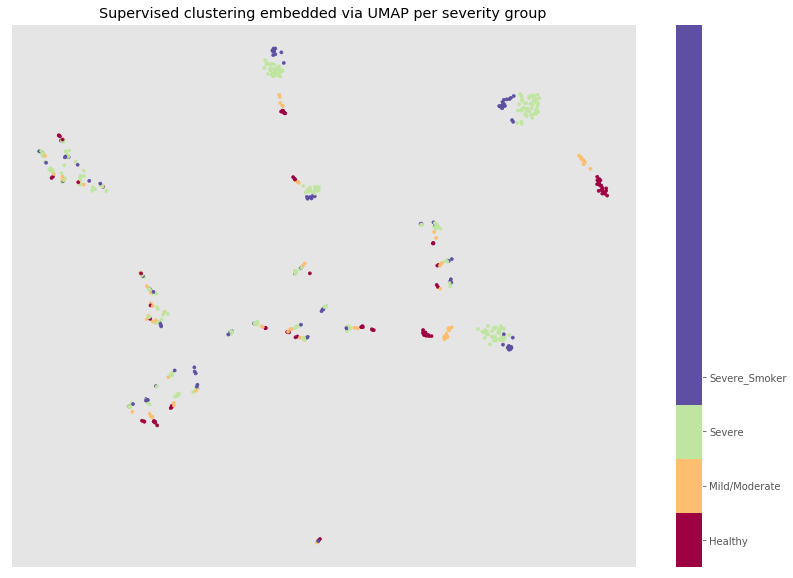

In [62]:
fig,ax = plt.subplots(1,figsize=(14,10))
plt.scatter(*embedding_sup.T, s = 10, c = df_sup_outcome['cohort'], cmap = 'Spectral', alpha =1.0)
plt.setp(ax,xticks = [], yticks = [])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title('Supervised clustering embedded via UMAP per severity group')
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/")
plt.savefig('Supervised_clustering_severity_umap.pdf',format='pdf', dpi=1000, bbox_inches='tight')

REITERATE BUT WITH THE 4 CLUSTERS YOU DEFINED

In [63]:
#Drop a few columns from df
df_sup_cluster = df_viz_sup.drop(['Unnamed: 0','X','Healthy','Severe','Severe_Smoker','Severe_asthma','MildModerate','cluster_K_2','cohort','cluster_K_6'], axis = 1)

In [68]:
#Check variable types for specific columns using:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df_sup_cluster.iloc[:,102:110].dtypes

Omics.Proteomics.Serum                              object
Questions.Screening.Asthma.Father                   object
Questions.Screening.Hay.Fever.Mother                object
Questions.Screening.Inflammatory.Disease.Father     object
Hay.Fever.Diagnosed                                 object
Non.Allergic.Rhinitis.Diagnosed                     object
Parental.Asthma                                     object
Clinical.Screening.Haematology.Not.Done            float64
dtype: object

In [69]:
#Convert range of variables 175-362 to object 
df_sup_cluster.iloc[:,102:110]=df_sup_cluster.iloc[:,102:110].astype('str')

#Label encode categorical variables
from sklearn import preprocessing
for c in df_sup_cluster.iloc[:,102:110]:
    le = preprocessing.LabelEncoder()
    df_sup_cluster[c] = le.fit_transform(np.array(df_sup_cluster[c]).reshape(-1, 1))
    
#Standardize using yeo-johnson transformation for all variables in df to be scaled identically
from sklearn.preprocessing import PowerTransformer
for c in df_sup_cluster.iloc[:,102:110]:
    pt = PowerTransformer()
    df_sup_cluster[c] =  pt.fit_transform(np.array(df_sup_cluster[c]).reshape(-1, 1))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [70]:
df_sup_cluster.head(5)

,Biomarker.C5a.pg.ml.serum,Biomarker.CD40L.pg.ml.serum,Biomarker.DPPIV.pg.ml.serum,Biomarker.Galectin.3.pg.ml.serum,Biomarker.IL.18.pg.ml.serum,Biomarker.IL.1alpha.pg.ml.serum,Biomarker.IL.6Ralpha.pg.ml.serum,Biomarker.LBP.pg.ml.serum,Biomarker.MCP.4.pg.ml.serum,Biomarker.MMP.3.pg.ml.serum,Biomarker.RAGE.pg.ml.serum,Biomarker.SHBG.pg.ml.serum,Biomarker.Serpin.E1.pg.ml.serum,Biomarker.alpha1.microglobulin.pg.ml.serum,Biomarker.CCL17.pg.ml.MSD.BL.plasma,Biomarker.EOTAXIN.pg.ml.MSD.BL.plasma,Biomarker.Baseline.BI.Cytokines.Chemokines.IL6.pg.ml.MSD.BL.plasma,Biomarker.MCP1.pg.ml.MSD.BL.plasma,Biomarker.MIP1b.pg.ml.MSD.BL.plasma,Biomarker.TNFa.pg.ml.MSD.BL.plasma,Biomarker.Genentech.CCL18.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.IL13.pg.ml.IMPACT.BL.serum,Biomarker.Genentech.Periostin.ng.ml.ELECSYS.BL.serum,Biomarker.Karolinska.hsCRP.hCRP.mg.L,Clinical.Atopy.Total.IgE.IU.ml,Clinical.NO.Standard.Flow.Rate,Clinical.Screening.Albumin.g.dL,Clinical.Screening.Alkaline.Phosphatase.U.L,Clinical.Screening.Alt.U.L.,Clinical.Screening.Ast.U.L,Clinical.Screening.Blood.Urea.Nitrogen.mg.dL,Clinical.Screening.Creatinine.umol.L,Clinical.Screening.Gamma.Gt.U.L,Clinical.Screening.Lymphocytes,Clinical.Screening.Monocytes,Clinical.Screening.Neutrophils,Clinical.Screening.Platelets.x10.3.uL,Clinical.Screening.Sodium.mmol.L,Clinical.Screening.Total.Bilirubin.umol.L,Clinical.Screening.Total.Protein.g.dL,Clinical.Screening.Wbcs.x10.3.uL,Clinical.Screening.eosinophils.x10.3.uL,Clinical.Screening.lymphocytes.x10.3.uL,Clinical.FEF.25.75.Absolute.Change.L.sec,Clinical.FEV1.FVC.Ratio.Predicted.LLN,Clinical.FVC.Absolute.Change.L,Clinical.Baseline.PEF,Clinical.Screening.Diastolic.Blood.Pressure,Clinical.Screening.Heart.Rate,Clinical.Screening.Respiratory.Rate,Clinical.Screening.Systolic.Blood.Pressure,Demographic.Age,Exacerbation.Per.Year.,Omics.dehydroTXB2.ng.mmolC,Omics.dinor.11.B.PGF2a.ng.mmolC,Omics.dinor.8.isoPGF2a.ng.mmolC,Omics.dinor.TXB2.ng.mmolC,Omics.isoPGF2a.ng.mmolC,Omics.LTE4.ng.mmolC,Omics.PGF2a.ng.mmolC,Omics.tetranorPGDM.ng.mmolC,Omics.tetranorPGEM.ng.mmolC,Omics.Trimethyluric.acid,Omics.Dimethyluric.acid,Omics.Methyluric.acid,Omics.Methylxanthine,Omics.Acetylamino.6.formylamino.3.methyluracil,Omics.Acetylcarnitine,Omics.Carnitine,Omics.Galacturonic.acid,Omics.Glutamine,Omics.Guanine,Omics.Histidine,Omics.Kynurenic.acid,Omics.Maltose,Omics.Mannitol,Omics.Methionine,Omics.Methylthioadenosine,Omics.N.Acetylcarnosine,Omics.N.Acetylglutamic.acid,Omics.N.Acetylputrescine,Omics.N.Methyl.D.aspartic.acid,Omics.N.Methylhistamine,Omics.Pipecolic.acid,Omics.Propionylcarnitine,Omics.S.Adenosylhomocysteine,Omics.Saccharopine,Omics.Sarcosine,Omics.Serine,Omics.Serotonin,Omics.Sucrose,Omics.Uracil,Omics.Xylose,Questionnaires.ACQ.FEV1.Precentage,Questionnaires.AQLQ.Emotional.Total.Imputed,Questionnaires.ESS.Total.Imputed,Questionnaires.HADS.Anxiety.Total.Imputed,Questionnaires.HADS.Depression.Total.Imputed,Questionnaires.SNOT.Total.Imputed,Body.Mass.Index.kg.m2,Height.cm,Respiratory.History.Onset.OR.First.Diagnosis.Age.years,Omics.Proteomics.Serum,Questions.Screening.Asthma.Father,Questions.Screening.Hay.Fever.Mother,Questions.Screening.Inflammatory.Disease.Father,Hay.Fever.Diagnosed,Non.Allergic.Rhinitis.Diagnosed,Parental.Asthma,Clinical.Screening.Haematology.Not.Done,cluster_K_4
Unnamed..0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A_005,0.229508,0.333360,0.517148,0.350924,0.192343,0.500000,0.347316,0.303933,0.243902,0.051612,0.361961,0.082350,0.265279,0.440303,0.051313,0.107015,0.0,0.414110,0.084239,0.50,0.256313,0.0,0.296610,0.000000,0.038614,0.143564,0.000000,0.252101,0.189189,0.160584,0.250000,0.276786,0.477444,0.666667,0.266667,0.322581,0.246231,0.666667,0.147059,0.8,0.3125,0,0.50,0.202703,0.384615,0.455882,0.689655,0.523810,0.120482,0.157895,0.813084,0.750000,0.0000,0.017241,0.112903,0.289788,0.027431,0.179348,0.028436,0.289796,0.128900,0.111971,0.273604,0.280313,0.053317,0.541940,0.1

In [74]:
#Drop a few columns from df
df_sup_cluster_2 = df_sup_cluster.drop(['cluster_K_4'], axis = 1)

In [78]:
#Visualize unsupervised clustering with points belonging to each cluster
fit_cluster_sup = umap.UMAP()
%time embedding_clust_sup = fit_cluster_sup.fit_transform(df_sup_cluster_2,y=df_sup_outcome['cohort'])

CPU times: user 19.6 s, sys: 30 ms, total: 19.6 s
Wall time: 5.14 s


In [84]:
classes_2 = ['Cluster1','Cluster2','Cluster3','Cluster4']

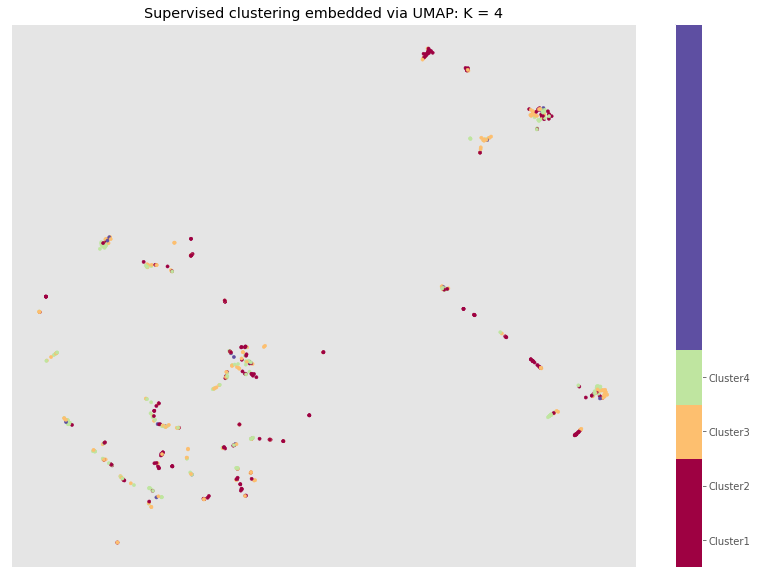

In [86]:
fig,ax = plt.subplots(1,figsize=(14,10))
plt.scatter(*embedding_clust_sup.T, s = 10, c = df_sup_cluster['cluster_K_4'], cmap = 'Spectral', alpha =1.0)
plt.setp(ax,xticks = [], yticks = [])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes_2)
plt.title('Supervised clustering embedded via UMAP: K = 4')
os.chdir("/rds/general/user/md2620/home/asthma/Malo/Results/")
plt.savefig('Supervised_clustering_clusters_umap.pdf',format='pdf', dpi=1000, bbox_inches='tight')